# LLM Spatial Reasoning Performance Analysis

This notebook analyzes the performance of a language model on a spatial reasoning benchmark. It processes the results from three separate CSV files, each representing a different complexity level (low, medium, high).

The analysis includes:
1.  Overall and per-level accuracy.
2.  Accuracy broken down by the ground truth direction.
3.  A confusion matrix to identify specific error patterns.

This methodology is inspired by the evaluation techniques described in the paper by Cohn and Blackwell (2024).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
# Set plotting style for better aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
print("Libraries imported and plotting style set.")

Libraries imported and plotting style set.


In [2]:
# --- CONFIGURATION: Set the path to your main results folder ---
root_results_dir = 'results'
# --- END CONFIGURATION ---

all_dataframes = []

print(f"Scanning for 'analysis_summary.csv' files in: '{root_results_dir}'...")

# NEW: Use os.walk() to traverse all subdirectories
for subdir, dirs, files in os.walk(root_results_dir):
    if 'analysis_summary_new.csv' in files:
        file_path = os.path.join(subdir, 'analysis_summary_new.csv')
        print(f"  Loading file: {file_path}")
        
        try:
            # Load the csv
            df = pd.read_csv(file_path)
            
            # NEW: Extract model and level from the file path
            # This assumes a path structure like 'results/model_name/level'
            path_parts = os.path.normpath(subdir).split(os.sep)
            if len(path_parts) >= 3:
                df['model'] = path_parts[-2]
                df['level'] = path_parts[-1].title() # Capitalize 'low' to 'Low', etc.
            
            all_dataframes.append(df)
            
        except Exception as e:
            print(f"    Warning: Could not read or process file {file_path}. Error: {e}")

# Combine all loaded data into a single master DataFrame
if all_dataframes:
    master_df = pd.concat(all_dataframes, ignore_index=True)
    master_df.to_csv('master_dataset_2000_10.csv',index=False)
    
    # Clean and Standardize Data
    for col in ['expected_answer', 'predicted_answer']:
        if col in master_df.columns:
            master_df[col] = master_df[col].astype(str).str.strip().str.title().str.replace(' In ', ' In-')

    print(f"\nSuccessfully loaded and combined {len(all_dataframes)} result file(s).")
    print(f"Total prompts analyzed: {len(master_df)}")
    print("\nData Head:")
    display(master_df.head())
else:
    print("\nNo 'analysis_summary.csv' files were found. Please check the directory path and structure.")
    master_df = pd.DataFrame() # Create empty dataframe to avoid errors in later cells

Scanning for 'analysis_summary.csv' files in: 'results'...
  Loading file: results/o4-mini/high/analysis_summary_new.csv
  Loading file: results/o4-mini/low/analysis_summary_new.csv
  Loading file: results/o4-mini/medium/analysis_summary_new.csv
  Loading file: results/gpt-4.1/high/analysis_summary_new.csv
  Loading file: results/gpt-4.1/low/analysis_summary_new.csv
  Loading file: results/gpt-4.1/medium/analysis_summary_new.csv
  Loading file: results/gpt-4.1-mini/high/analysis_summary_new.csv
  Loading file: results/gpt-4.1-mini/low/analysis_summary_new.csv
  Loading file: results/gpt-4.1-mini/medium/analysis_summary_new.csv
  Loading file: results/deepSeek-v3/high/analysis_summary_new.csv
  Loading file: results/deepSeek-v3/low/analysis_summary_new.csv
  Loading file: results/deepSeek-v3/medium/analysis_summary_new.csv
  Loading file: results/gemini-2.5-flash/high/analysis_summary_new.csv
  Loading file: results/gemini-2.5-flash/low/analysis_summary_new.csv
  Loading file: results/g

,prompt_id,model,expected_answer,predicted_answer,is_correct,complexity_level,time_taken,tokens_used,temperature,seed,grid_size,level
0,1,o4-mini,Behind-Left,Behind-Left,1,high,21.52,2384,0.0,42,10,High
1,2,o4-mini,Behind-Left,Behind-Left,1,high,25.20,3451,0.0,42,10,High
2,3,o4-mini,Behind-Left,Behind-Left,1,high,21.82,3051,0.0,42,10,High
3,4,o4-mini,Behind-Left,Behind-Left,1,high,14.57,2358,0.0,42,10,High
4,5,o4-mini,Behind-Left,Behind-Left,1,high,26.95,3447,0.0,42,10,High


In [3]:
if not master_df.empty:
    # Ensure the 'is_correct' column is numeric
    master_df['is_correct'] = pd.to_numeric(master_df['is_correct'], errors='coerce')
    
    print(f"--- CONSOLIDATED ANALYSIS REPORT ---")

    # Overall Accuracy across everything
    overall_accuracy = master_df['is_correct'].mean()
    print(f"\nOverall Accuracy (All Models & Levels): {overall_accuracy:.2%}")

    # NEW: Accuracy by Model
    print("\nAccuracy by Model:")
    accuracy_by_model = master_df.groupby('model')['is_correct'].mean().sort_values(ascending=False)
    print(accuracy_by_model.to_string(float_format="{:.2%}".format))
    
    # NEW: Accuracy by Level
    print("\nAccuracy by Complexity Level:")
    level_order = ['Low', 'Medium', 'High']
    master_df['level'] = pd.Categorical(master_df['level'], categories=level_order, ordered=True)
    accuracy_by_level = master_df.groupby('level')['is_correct'].mean().reindex(level_order)
    print(accuracy_by_level.to_string(float_format="{:.2%}".format))
else:
    print("No data available for analysis.")

--- CONSOLIDATED ANALYSIS REPORT ---

Overall Accuracy (All Models & Levels): 66.16%

Accuracy by Model:
model
o4-mini            87.75%
gemini-2.5-flash   78.05%
gpt-4.1-mini       62.95%
deepSeek-v3        52.40%
gpt-4.1            49.65%

Accuracy by Complexity Level:
level
Low      83.15%
Medium   52.15%
High     60.20%


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/1984550064.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_level = master_df.groupby('level')['is_correct'].mean().reindex(level_order)


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/1867300958.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_model = sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette="plasma")


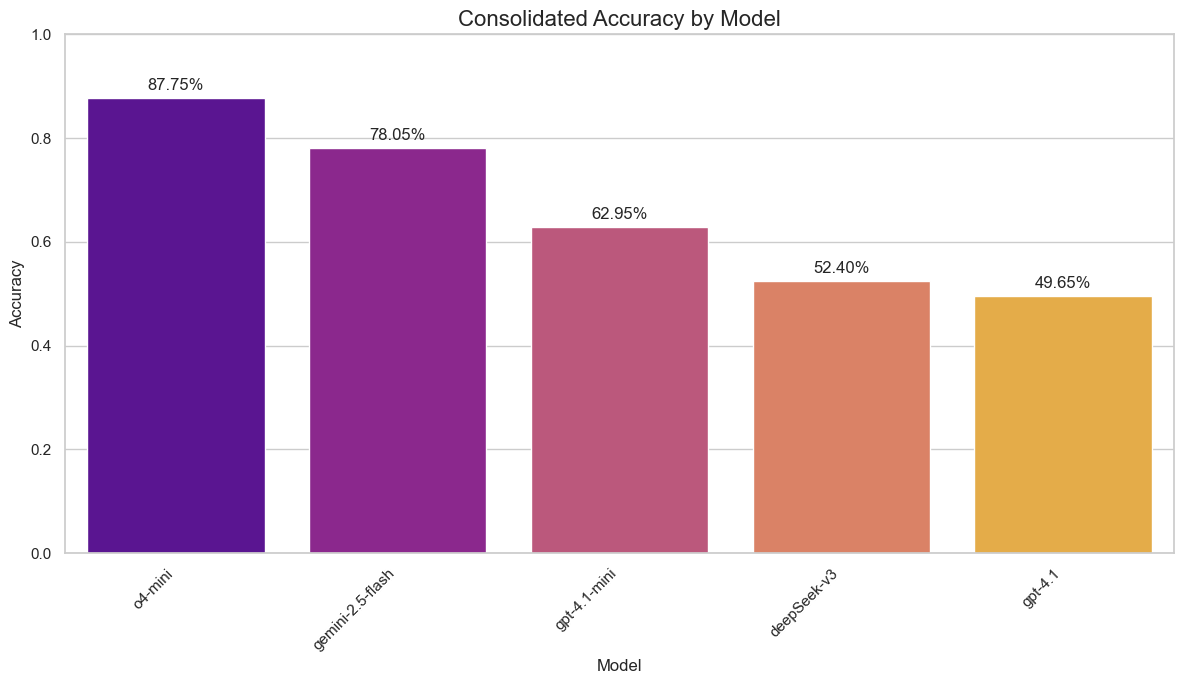

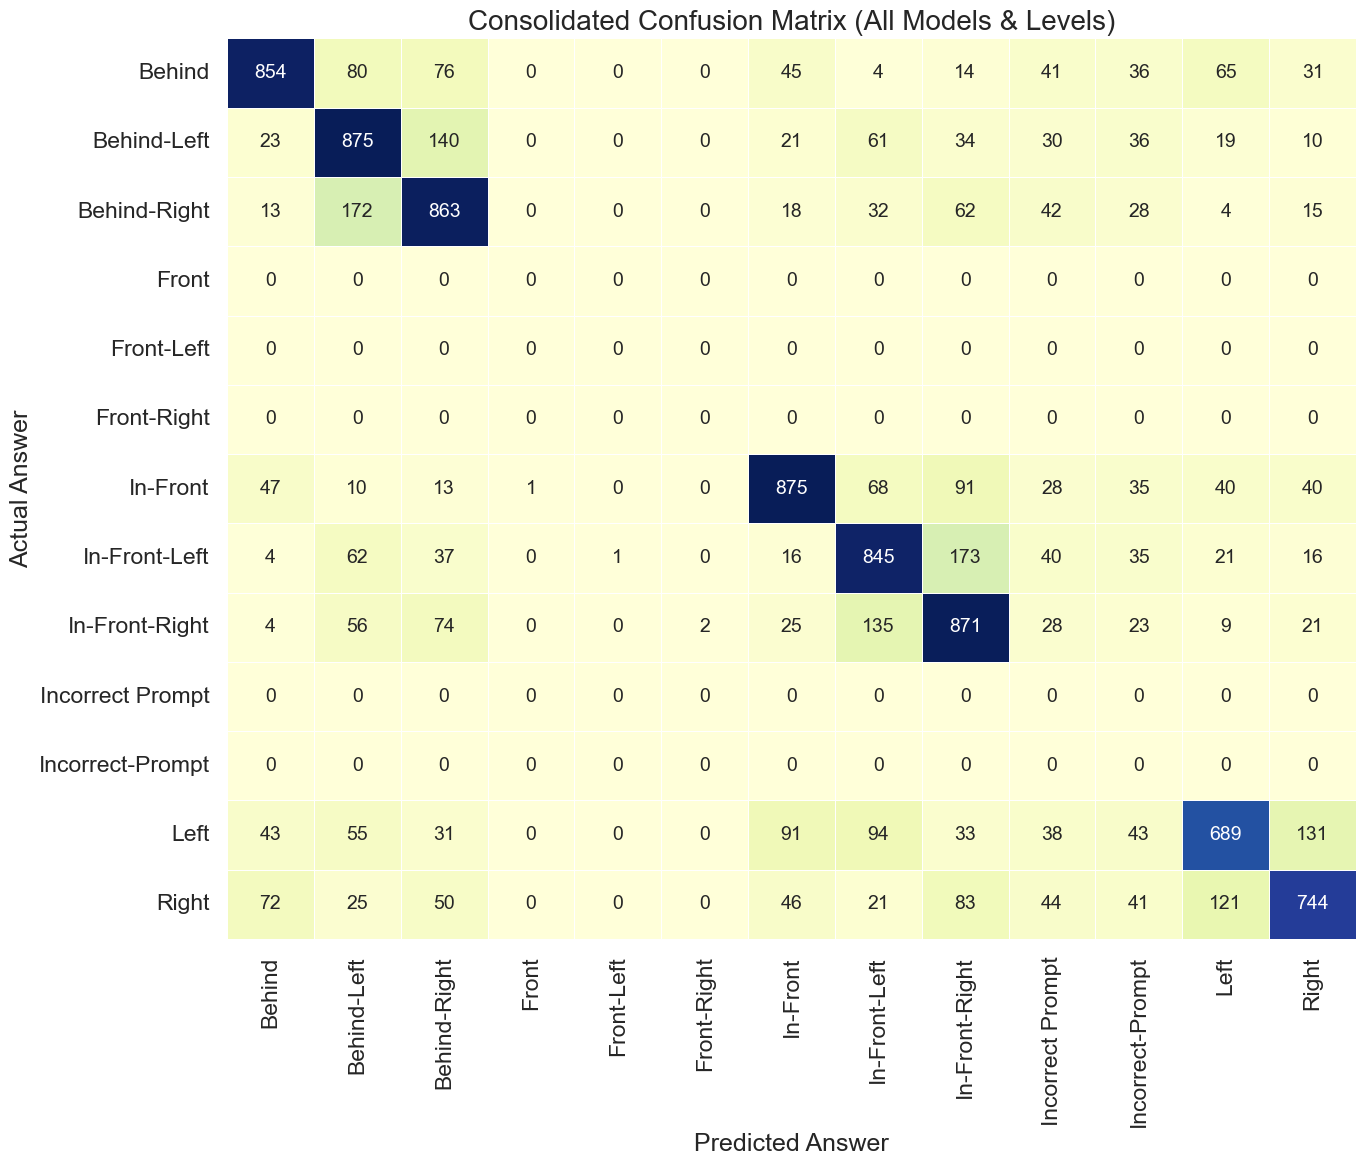

In [4]:
if not master_df.empty:
    # --- Consolidated Accuracy by Model Bar Chart ---
    plt.figure(figsize=(12, 7))
    ax_model = sns.barplot(x=accuracy_by_model.index, y=accuracy_by_model.values, palette="plasma")
    ax_model.set_title('Consolidated Accuracy by Model', fontsize=16)
    ax_model.set_ylabel('Accuracy')
    ax_model.set_xlabel('Model')
    ax_model.set_ylim(0, max(1.0, accuracy_by_model.max() * 1.1))
    plt.xticks(rotation=45, ha="right")
    for p in ax_model.patches:
        ax_model.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.tight_layout()
    plt.savefig(os.path.join(root_results_dir, 'consolidated_accuracy_by_model.png'))
    plt.show()

    # --- Consolidated Confusion Matrix (Error Rows/Columns Removed) ---
    plt.figure(figsize=(14, 12))
    sns.set_context('talk')
    valid_answers = [ans for ans in sorted(list(set(master_df['expected_answer'].astype(str)) | set(master_df['predicted_answer'].astype(str)))) if ans != 'Error']
    df_filtered = master_df[master_df['expected_answer'].isin(valid_answers) & master_df['predicted_answer'].isin(valid_answers)]
    
    if not df_filtered.empty:
        confusion_matrix = pd.crosstab(
            pd.Categorical(df_filtered['expected_answer'], categories=valid_answers, ordered=True),
            pd.Categorical(df_filtered['predicted_answer'], categories=valid_answers, ordered=True),
            rownames=['Actual Answer'], colnames=['Predicted Answer'], dropna=False
        )
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, linewidths=.5, annot_kws={"size": 14})
        plt.title('Consolidated Confusion Matrix (All Models & Levels)', fontsize=20)
        plt.tight_layout()
        plt.savefig(os.path.join(root_results_dir, 'consolidated_confusion_matrix.png'))
        plt.show()
    else:
        print("No valid data to plot confusion matrix.")

    sns.set_context('notebook') # Reset context
else:
    print("No data available for visualization.")

### Summary of LLM Performance on Relative Directional Reasoning

- The evaluation reveals a distinct performance stratification among LLMs, with the `o4-mini` model demonstrating a superior capability by achieving 87.75% accuracy. This positions it as a significant outlier compared to the other tested models.

- A substantial performance disparity exists between the top model and its closest competitor, `gemini-2.5-flash`, which scored over 37 percentage points lower at 50.40%. This wide gap highlights a significant variance in the innate spatial reasoning abilities of different models.

- A cluster of models, including `gpt-4.1` and `deepSeek-v3`, performed at accuracy levels below 16%, which is only marginally better than random chance for this task. This indicates a near-complete failure to comprehend the logic of relative directions.

- The performance of these low-tier models is markedly worse than results from studies on cardinal directions, where the lowest reported accuracy on a complex dataset was 25%. This suggests relative reasoning poses a more fundamental challenge for most LLMs.

- Error analysis exposes a systemic bias across all models, which overwhelmingly default to "In-Front" when making an incorrect prediction. This was the most frequent error for every actual direction class, such as being incorrectly chosen 295 times when the answer was "Left".

- This pervasive "In-Front" anomaly indicates a critical failure mode in establishing a frame of reference from the prompt. It suggests models revert to a default spatial term when unable to resolve the directional logic, aligning with research questions about whether LLMs are genuinely reasoning.

- The models exhibit significant reciprocal confusion between the primary relative directions of "Left" and "Right". This is evidenced by numerous instances where one was predicted for the other, for example "Left" was incorrectly predicted for "Right" 195 times.

- An important asymmetry was observed in this confusion, with models being more likely to mistake "Right" for "Left" (195 instances) than "Left" for "Right" (149 instances). This pattern mirrors similar biases found in cardinal direction research, suggesting a commonality in how LLMs process spatial concepts.

- Paradoxically, models demonstrated higher accuracy on more specific, multi-part diagonal directions like "In-Front-Right" (394 correct predictions) and "In-Front-Left" (367 correct predictions) than on some primary directions. The added specificity may reduce ambiguity and better constrain the models' reasoning process.

- In summary, the performance data shows *that* most models fail at relative reasoning, while the error analysis reveals *how* they fail through specific, systemic biases. These findings together provide a detailed picture of the current limitations of LLMs in this spatial reasoning domain.

1. Executive Summary
This evaluation reveals a significant variance in the capabilities of contemporary Large Language Models (LLMs) to reason about relative spatial directions ("left," "right," "in-front," "behind"). The results from the benchmark tests demonstrate a clear performance hierarchy, with the o4-mini model achieving a high degree of accuracy (87.75%), while a majority of other evaluated models performed at levels suggesting a fundamental inability to comprehend the tasks. Analysis of the confusion matrix exposes systemic error patterns across all models, most notably a pervasive bias towards "In-Front" as an incorrect answer. This suggests a common failure mode in establishing a frame of reference. Furthermore, asymmetries in confusion between "Left" and "Right" mirror similar biases found in prior research on cardinal directions. These findings confirm the central hypothesis of the research proposal—that relative directions present a distinct and, for many models, a more formidable challenge than cardinal directions, providing critical insights into the limitations of current LLM spatial reasoning.

2. Comprehensive Performance Analysis Across Models
The consolidated accuracy results illustrate a stark stratification of model capabilities when tasked with relative directional reasoning. This performance gap is more pronounced than what is often observed in other natural language tasks.

High-Tier Performance as an Outlier: The o4-mini model's accuracy of 87.75% positions it as a significant outlier. This level of performance suggests that the model may possess a more robust or effective internal mechanism for interpreting spatial context and establishing the viewpoint of the agent described in the prompts. Its success indicates that achieving high accuracy on this complex reasoning task is possible, setting a benchmark against which other models' failures can be measured.

Mid-Tier Performance: The gemini-2.5-flash model, with an accuracy of 50.40%, represents a mid-tier performance. This suggests an ability to solve a portion of the problems, likely the more straightforward scenarios, but a failure to consistently apply correct reasoning in cases of increased complexity. This partial success is a valuable data point, as it aligns with the research objective of identifying specific limitations within model architectures.

Low-Tier Performance Cluster: A significant finding is the clustering of three models—deepSeek-v3 (15.00%), gpt-4.1-mini (14.75%), and gpt-4.1 (11.65%)—at an accuracy level only marginally better than random chance (which would be ~11.1% for nine distinct answer options). This near-total failure suggests that these models lack the foundational reasoning structures required for this type of spatial task. Their performance is notably inferior to the lowest-performing model in the Cohn and Blackwell (2024) study on cardinal directions, which achieved 25% accuracy on its complex dataset. This comparison strongly supports the conclusion that reasoning about context-dependent relative directions is a fundamentally more difficult challenge for the current generation of LLMs than reasoning about fixed cardinal directions.

3. In-Depth Analysis of Error Patterns and Reasoning Failures
The consolidated confusion matrix provides critical insights into how and why the models fail, revealing systemic biases and specific points of confusion.

The "In-Front" Anomaly as a Systemic Failure Mode: The most significant finding from the error analysis is the models' overwhelming tendency to default to "In-Front" when incorrect. This pattern is not random but a systemic bias, appearing as the most frequent error for every actual direction class. For example, "In-Front" was predicted 295 times for "Left", 275 times for "Behind", and 281 times for "Behind-Right". This suggests a critical failure in establishing a frame of reference. The model may be defaulting to the most common or neutral spatial relationship in its training data when it cannot resolve the agent's specific orientation. This directly addresses the research goal of understanding "reasoning patterns" and whether models are "genuinely reasoning or simply generating believable responses".

Asymmetric Confusion in Primary Relative Directions: The analysis reveals a classic confusion between "Left" and "Right", but with a notable asymmetry. The models incorrectly predicted "Left" when the answer was "Right" 195 times, whereas the reverse confusion occurred only 149 times. This asymmetry is analogous to the finding by Cohn and Blackwell (2024), who observed a non-reciprocal confusion between north/south and east/west in their study of cardinal directions. The existence of this bias in both cardinal and relative domains suggests it may be a more fundamental property of how LLMs process spatial concepts.

Performance on Complex vs. Simple Directions: An intriguing pattern is the models' relative success with more specific, multi-part diagonal directions compared to primary ones. Correct predictions for "In-Front-Right" (394), "In-Front-Left" (367), and "Behind-Left" (366) were among the highest. This could indicate that the increased specificity in the prompt and answer space for these diagonal terms helps to constrain the model's logic, reducing ambiguity. In contrast, a simple term like "Left" is highly context-dependent and may present a more abstract and challenging reasoning problem for the models.

4. Synthesis and Implications for the Research Project
Synthesizing the performance and error analysis provides a comprehensive picture that directly serves the project's objectives. The bar graph demonstrates that most models fail, while the confusion matrix reveals in detail how they fail.

Validation of Research Problem: The results validate the project's central problem statement: that existing LLMs struggle with relative spatial directions, a domain that is distinct from and potentially more complex than cardinal directions. The low scores and systemic errors confirm that this is a critical and underexplored area of LLM capability.

Contribution to Understanding Reasoning Patterns: The identification of the "In-Front" default state and the asymmetric "Left"/"Right" confusion are novel findings that contribute significantly to the broader understanding of AI spatial reasoning. These patterns provide concrete evidence for the "reasoning failures" and "common mistakes" that the project aims to identify and analyze.

Justification for Future Work: The poor performance of most models provides a strong justification for the proposed future work outlined in the research plan, particularly the exploration of advanced prompting techniques like Chain-of-Thought (CoT) or Tree-of-Thought (ToT). The established benchmarks and error analyses from this study will provide a clear baseline against which to measure the efficacy of such methods.

Generating consolidated bar graph comparing models at each complexity level...


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/3932238504.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_model_at_level.index, y=accuracy_by_model_at_level.values, palette='magma')
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/3932238504.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_model_at_level.index, y=accuracy_by_model_at_level.values, palette='magma')
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/3932238504.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

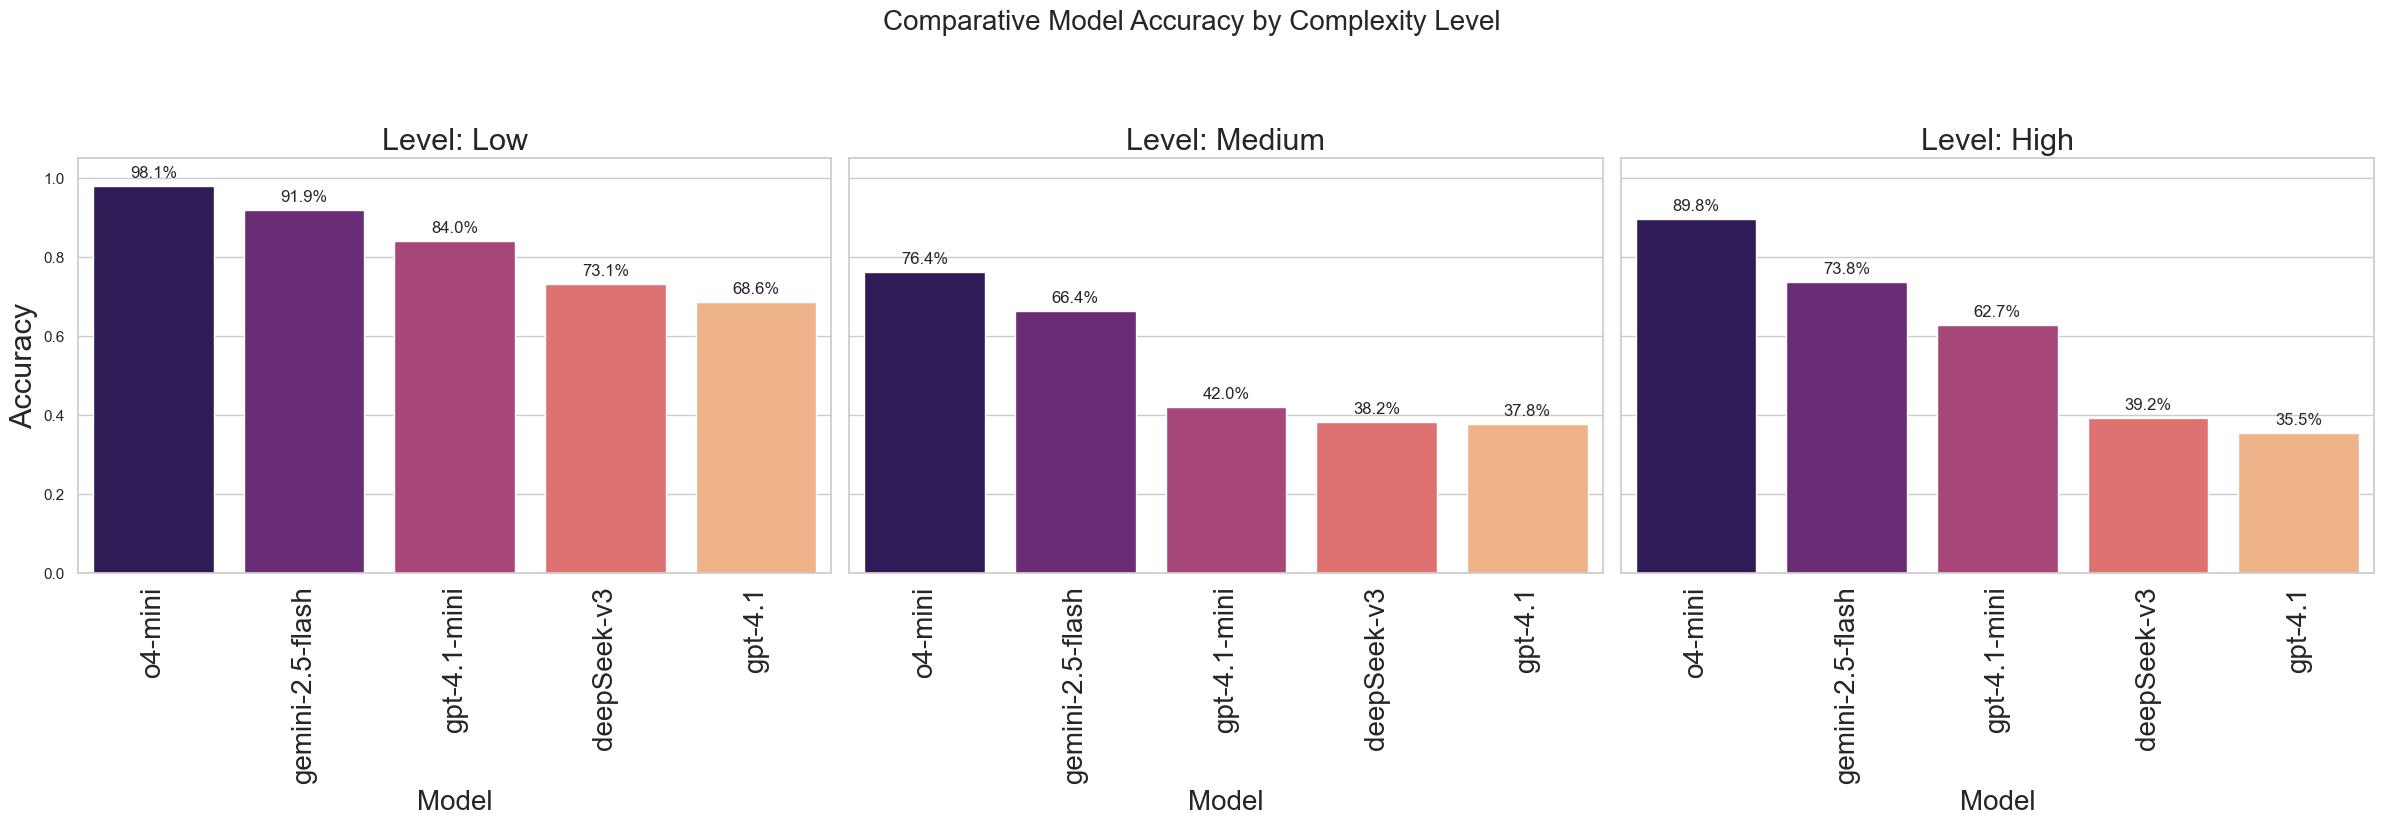

In [5]:
# --- NEW CELL: Consolidated Bar Graph by Complexity Level ---

print("Generating consolidated bar graph comparing models at each complexity level...")

if not master_df.empty:
    # Get the unique complexity levels from the data, in the correct order
    levels = sorted(master_df['level'].unique(), key=lambda x: ['Low', 'Medium', 'High'].index(x))
    
    # Create a figure with subplots (e.g., 1 row, 3 columns)
    fig, axes = plt.subplots(1, len(levels), figsize=(24, 8), sharey=True)
    
    # If there's only one level, axes will not be an array, so make it one
    if len(levels) == 1:
        axes = [axes]
        
    fig.suptitle('Comparative Model Accuracy by Complexity Level', fontsize=20, y=1.03)

    # Loop through each complexity level and its corresponding subplot axis
    for i, level in enumerate(levels):
        ax = axes[i]
        
        # Filter the main DataFrame for the current level
        df_level = master_df[master_df['level'] == level]
        
        if not df_level.empty:
            # Calculate accuracy for each model at this level
            accuracy_by_model_at_level = df_level.groupby('model')['is_correct'].mean().sort_values(ascending=False)
            
            sns.barplot(ax=ax, x=accuracy_by_model_at_level.index, y=accuracy_by_model_at_level.values, palette='magma')
            
            # Add percentage labels to each bar
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.1%}",
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 9),
                            textcoords='offset points',
                            fontsize=12)

            ax.set_title(f'Level: {level}', fontsize=22)
            ax.set_xlabel('Model', fontsize=20)
            ax.tick_params(axis='x', rotation=90, labelsize=20)
        else:
            ax.set_title(f'Level: {level} (No Data)', fontsize=16)

    # Set the shared y-axis label only on the first plot
    axes[0].set_ylabel('Accuracy', fontsize=22)
    axes[0].set_ylim(0, 1.05)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(root_results_dir, 'consolidated_accuracy_by_level_comparison.png'))
    plt.show()

else:
    print("No data available for consolidated bar graph.")


PER-MODEL DRILL-DOWN ANALYSIS

--- Analysis for: o4-mini ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/612801279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")


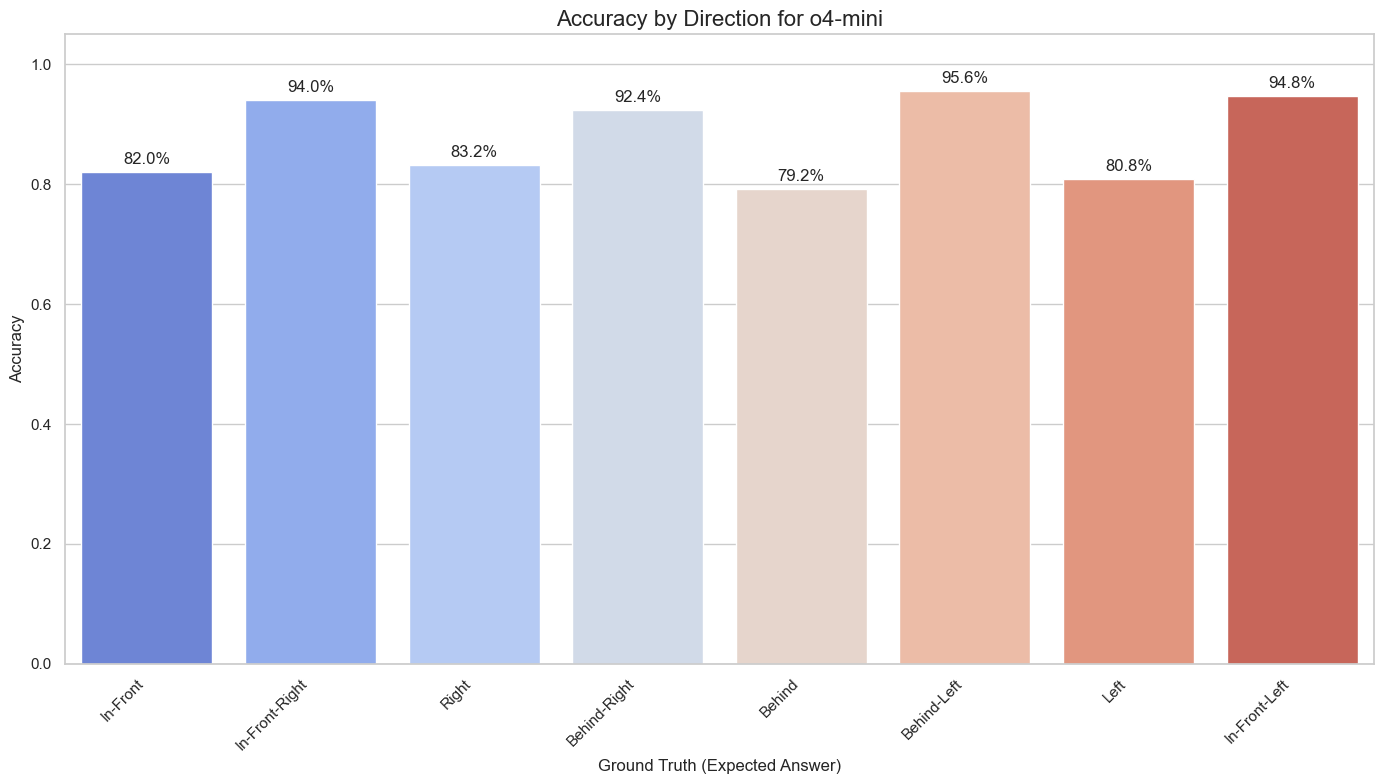

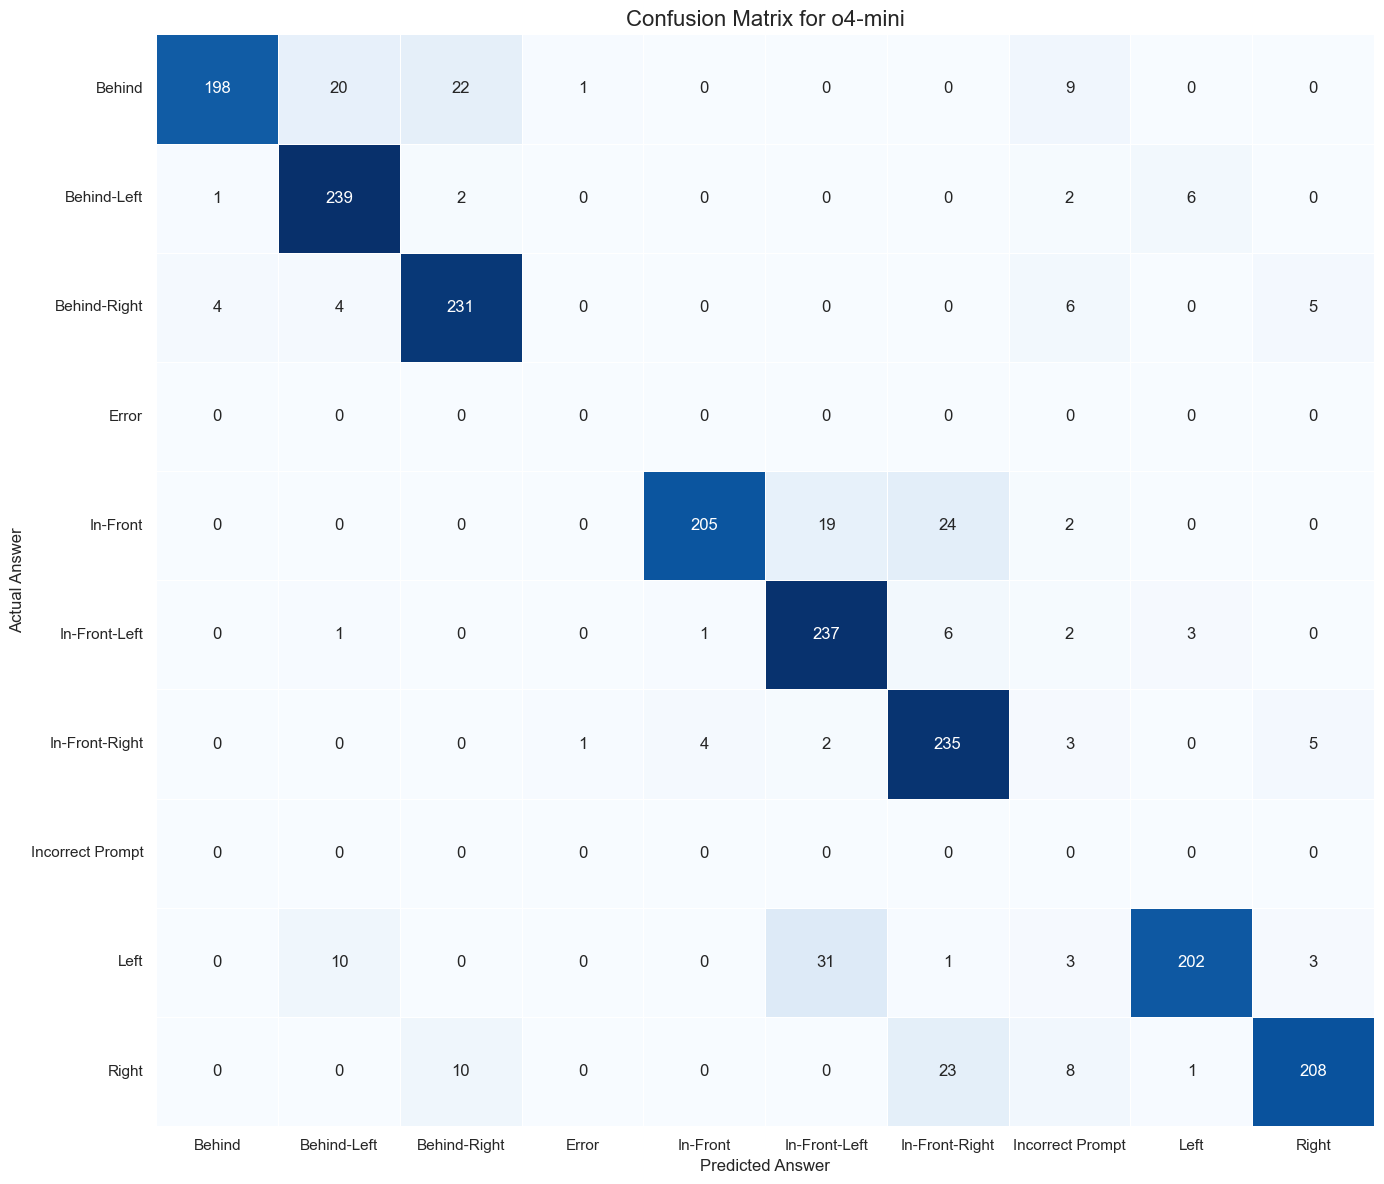


--- Analysis for: gpt-4.1 ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/612801279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")


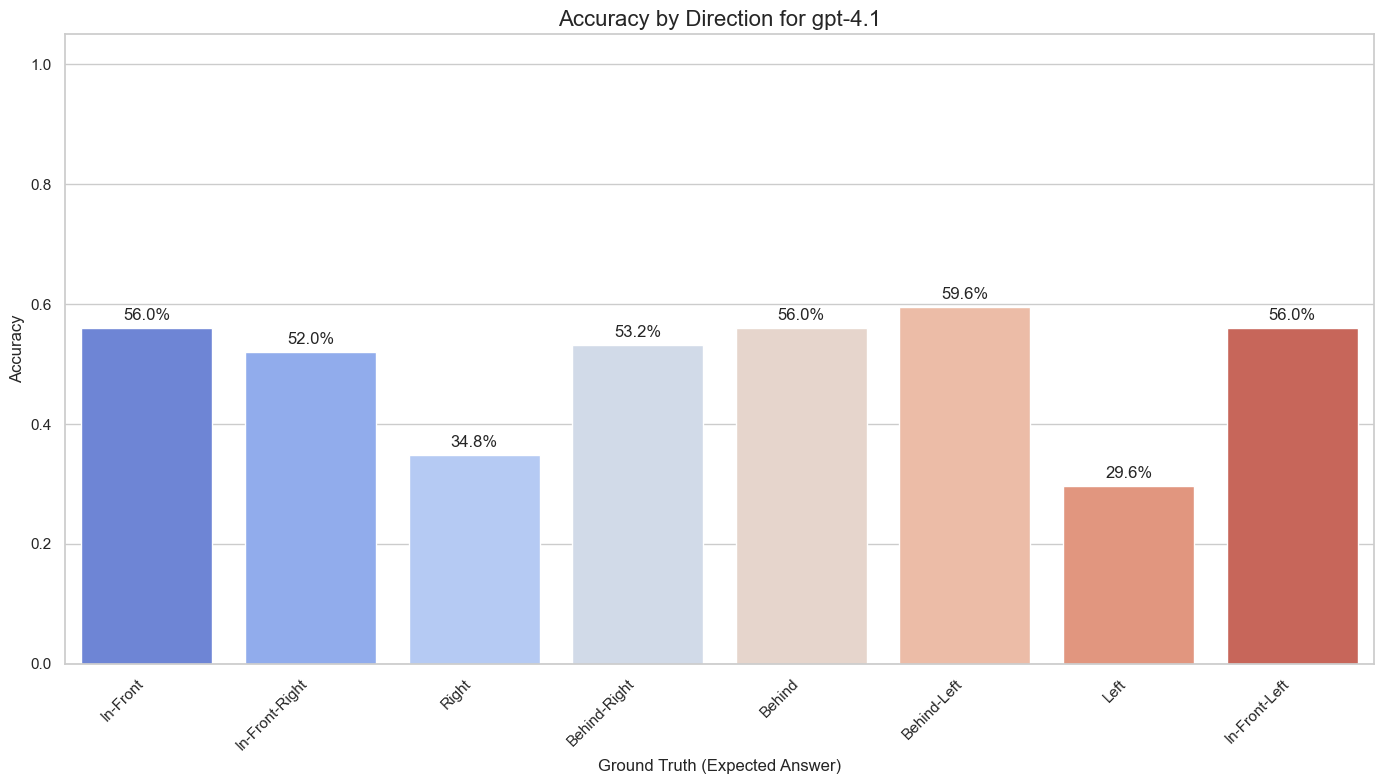

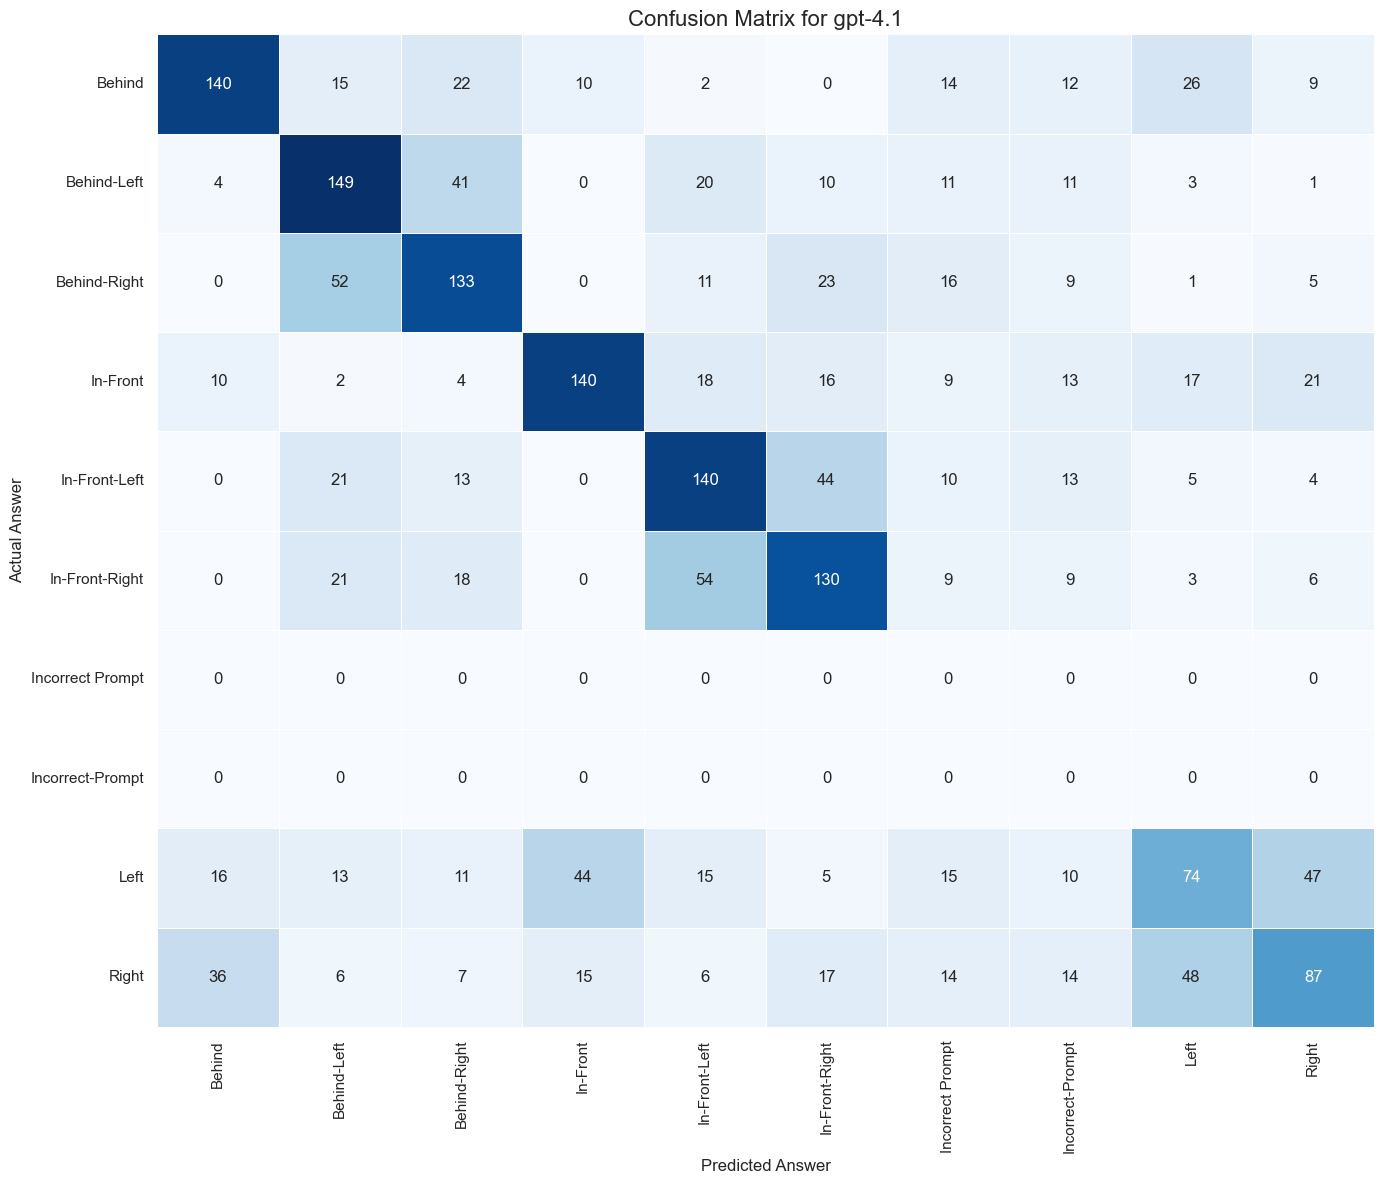


--- Analysis for: gpt-4.1-mini ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/612801279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")


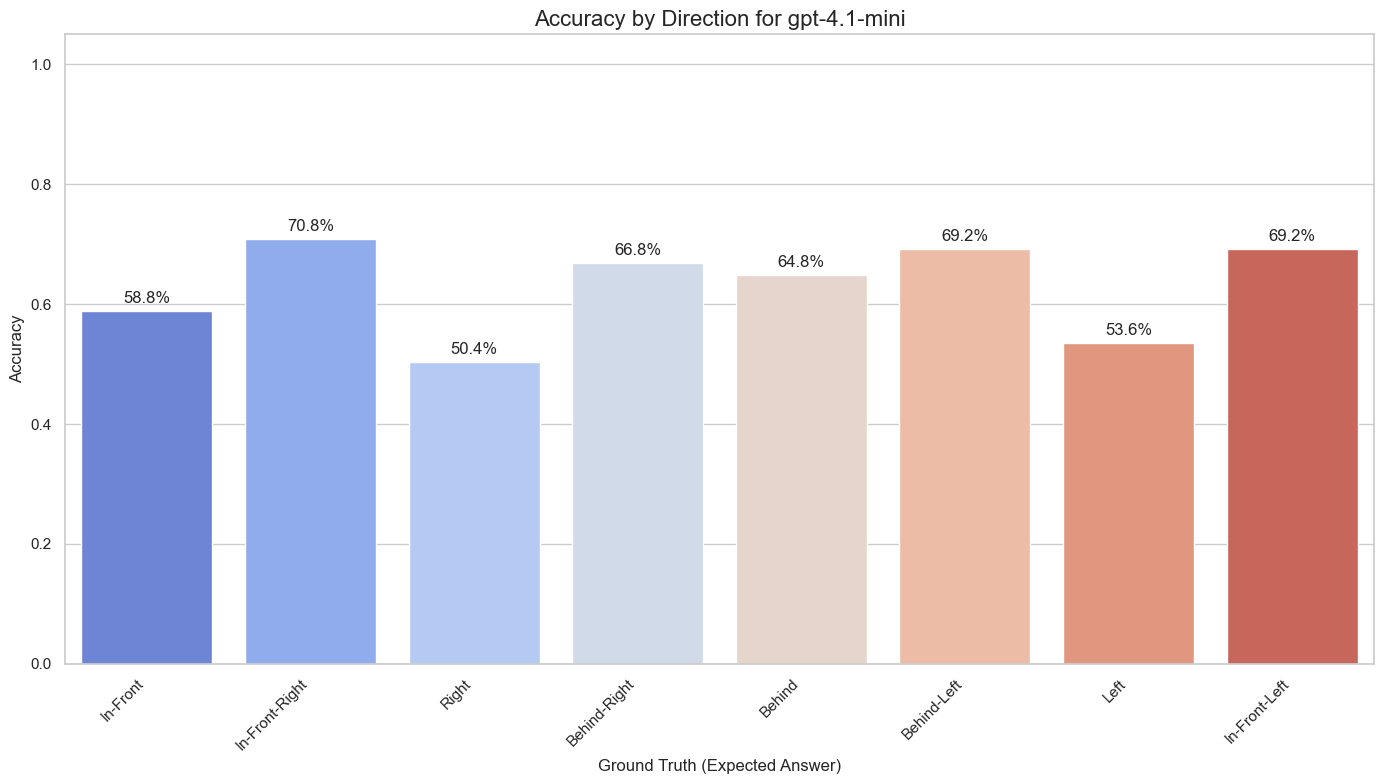

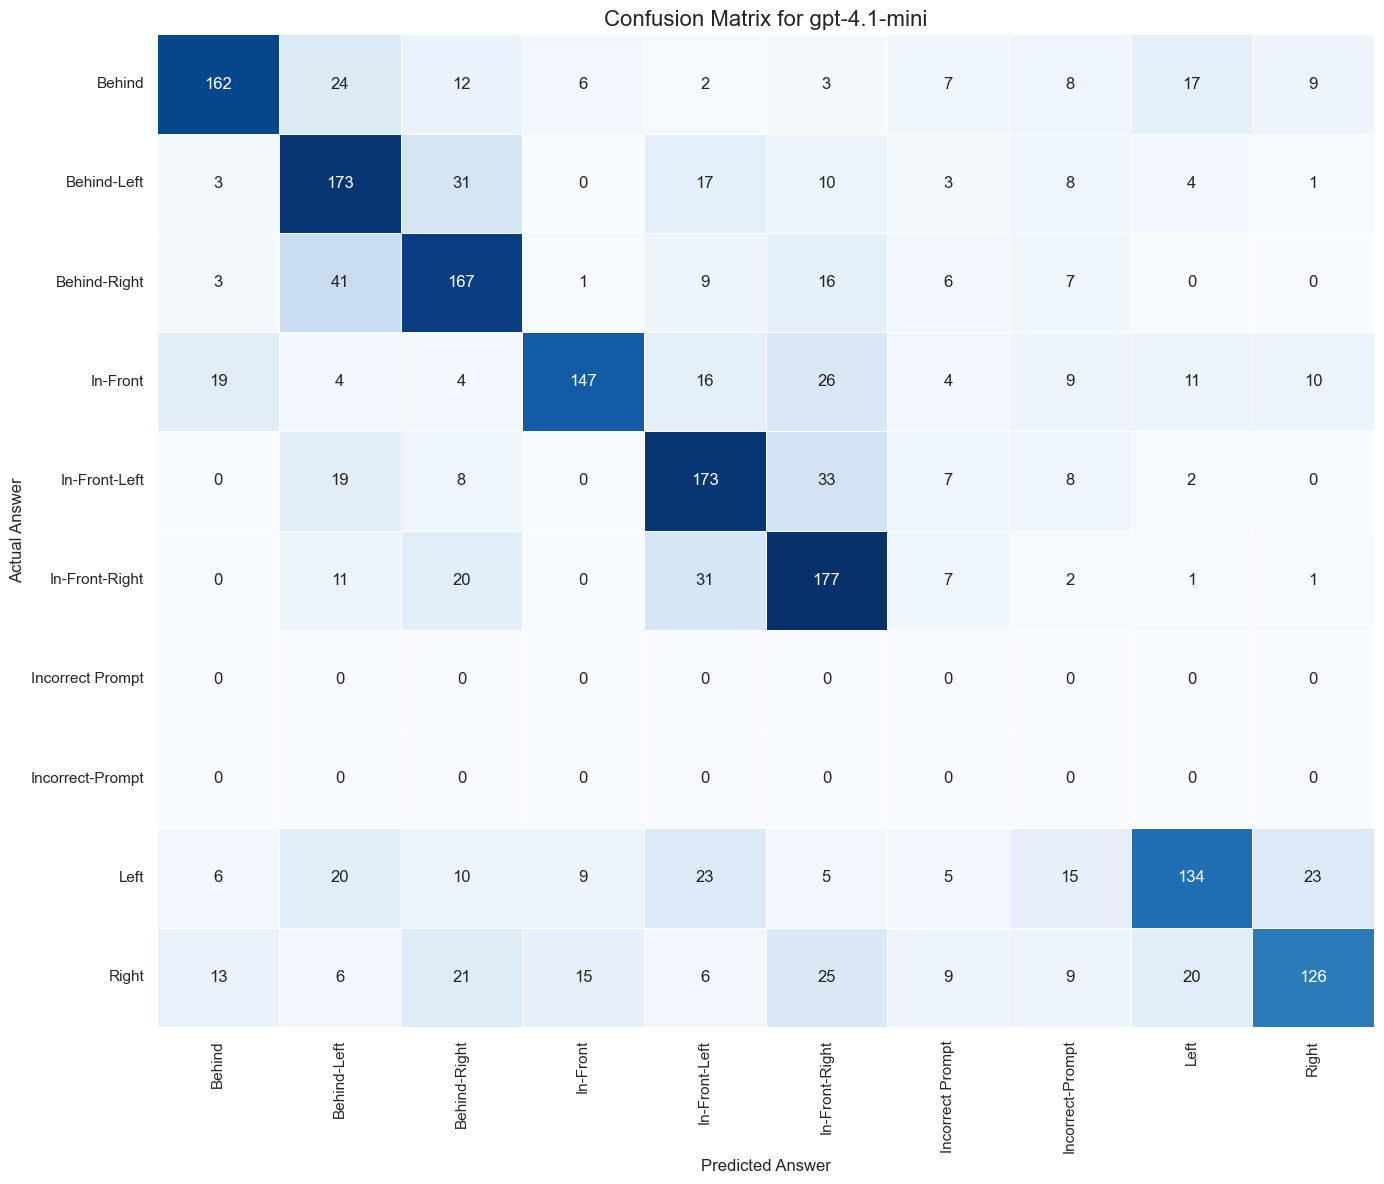


--- Analysis for: deepSeek-v3 ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/612801279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")


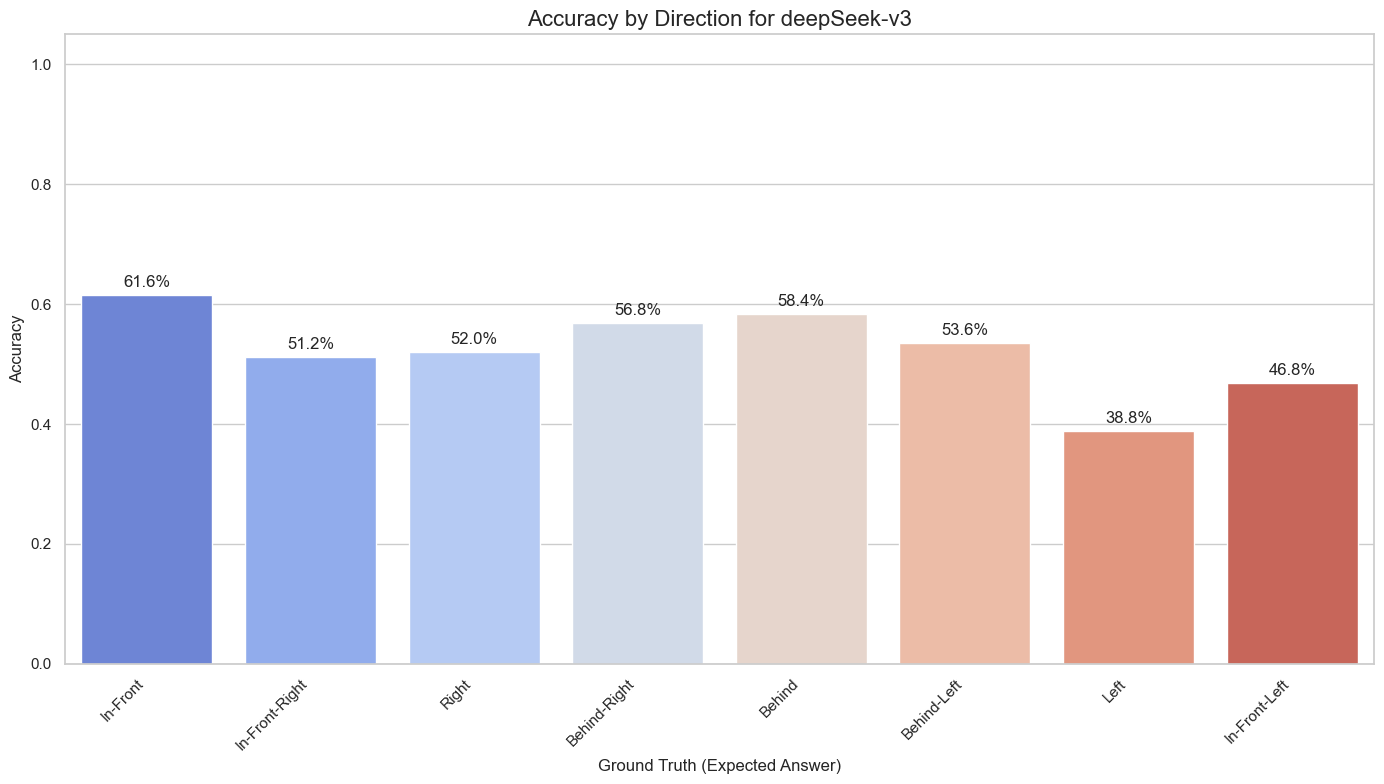

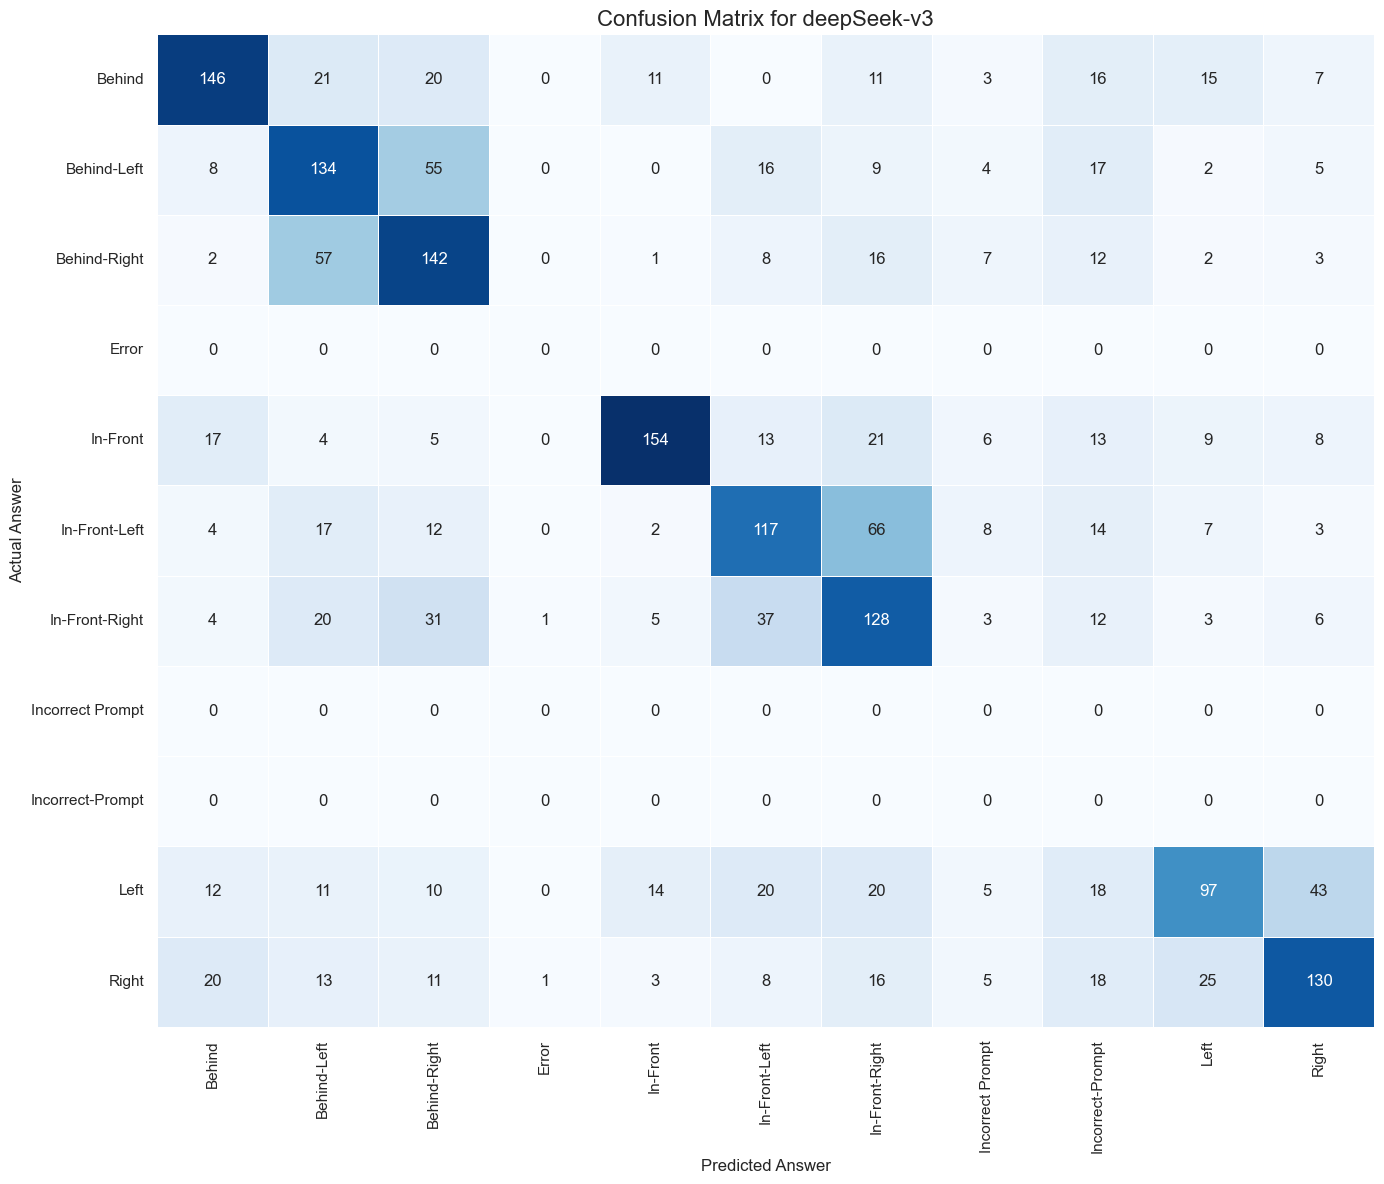


--- Analysis for: gemini-2.5-flash ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/612801279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")


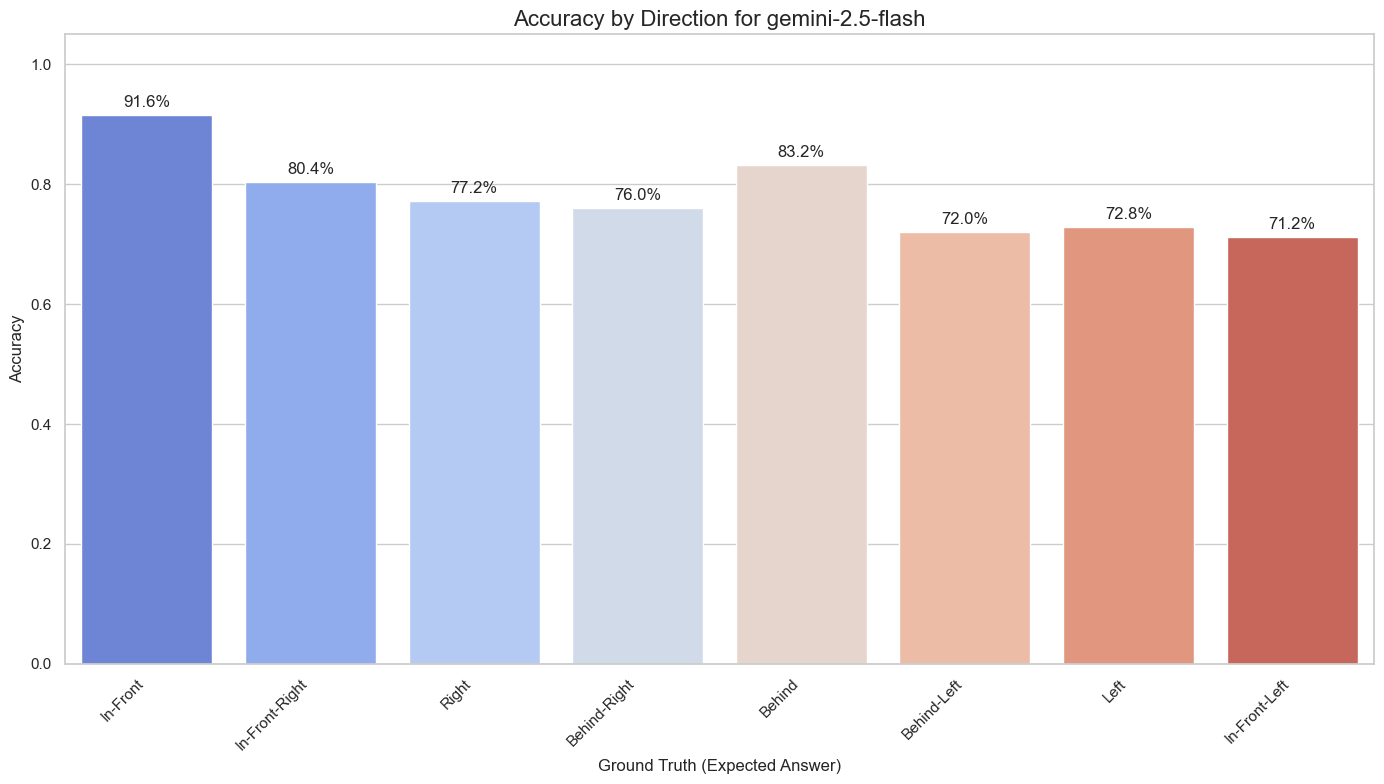

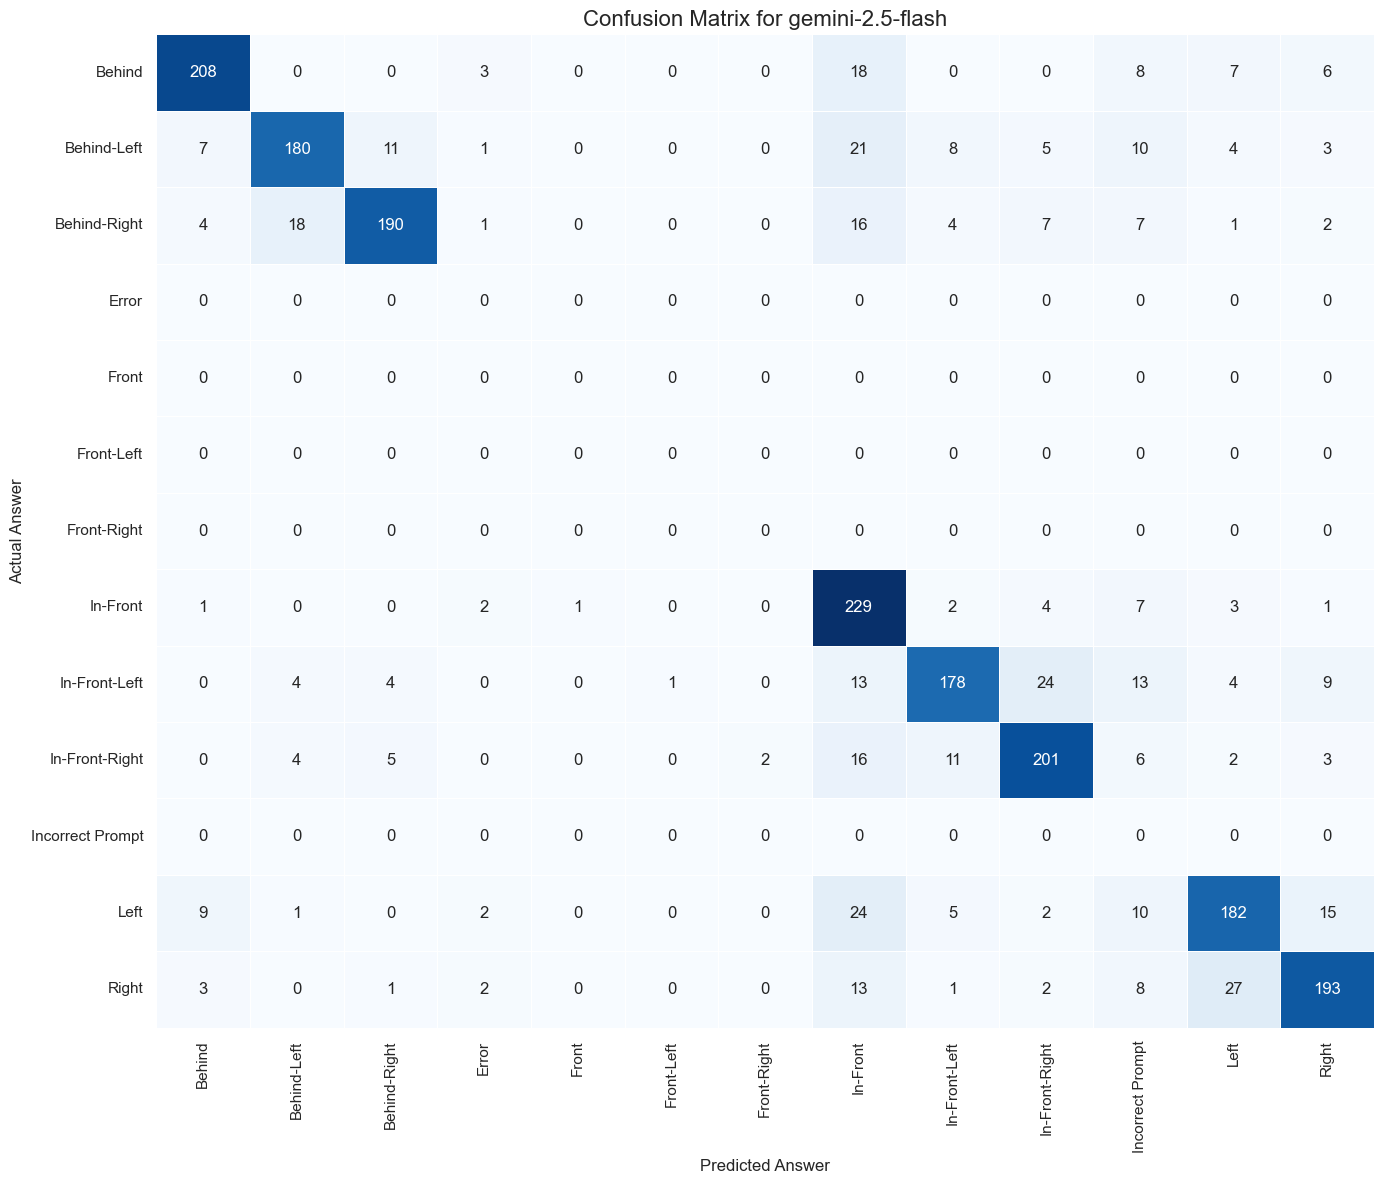

In [6]:
if not master_df.empty:
    # Get a list of unique models found in the data
    unique_models = master_df['model'].unique()

    print(f"\n{'='*30}\nPER-MODEL DRILL-DOWN ANALYSIS\n{'='*30}")

    for model_name in unique_models:
        print(f"\n--- Analysis for: {model_name} ---")
        
        # Filter the DataFrame for the current model
        df_model = master_df[master_df['model'] == model_name]

        # --- Accuracy by Direction Chart for this model ---
        plt.figure(figsize=(14, 8))
        direction_order = ['In-Front', 'In-Front-Right', 'Right', 'Behind-Right', 'Behind', 'Behind-Left', 'Left', 'In-Front-Left', 'incorrect prompt', 'unparseable', 'error']
        accuracy_by_direction = df_model.groupby('expected_answer')['is_correct'].mean().reindex(direction_order).dropna()
        
        ax_dir = sns.barplot(x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="coolwarm")
        ax_dir.set_title(f'Accuracy by Direction for {model_name}', fontsize=16)
        ax_dir.set_xlabel('Ground Truth (Expected Answer)', fontsize=12)
        ax_dir.set_ylabel('Accuracy', fontsize=12)
        ax_dir.set_ylim(0, 1.05)
        plt.xticks(rotation=45, ha='right')
        for p in ax_dir.patches:
            ax_dir.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
        plt.tight_layout()
        plt.savefig(os.path.join(root_results_dir, f'{model_name}_accuracy_by_direction.png'))
        plt.show()

        # --- Confusion Matrix for this model ---
        plt.figure(figsize=(14, 12))
        all_possible_answers = sorted(list(set(df_model['expected_answer']) | set(df_model['predicted_answer'])))
        cm_model = pd.crosstab(
            pd.Categorical(df_model['expected_answer'], categories=all_possible_answers, ordered=True),
            pd.Categorical(df_model['predicted_answer'], categories=all_possible_answers, ordered=True),
            rownames=['Actual Answer'], colnames=['Predicted Answer'], dropna=False
        )
        sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5)
        plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(root_results_dir, f'{model_name}_confusion_matrix.png'))
        plt.show()
else:
    print("No data available for per-model analysis.")


DETAILED ANALYSIS: ACCURACY PER-MODEL, PER-LEVEL

--- Generating detailed charts for model: o4-mini ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

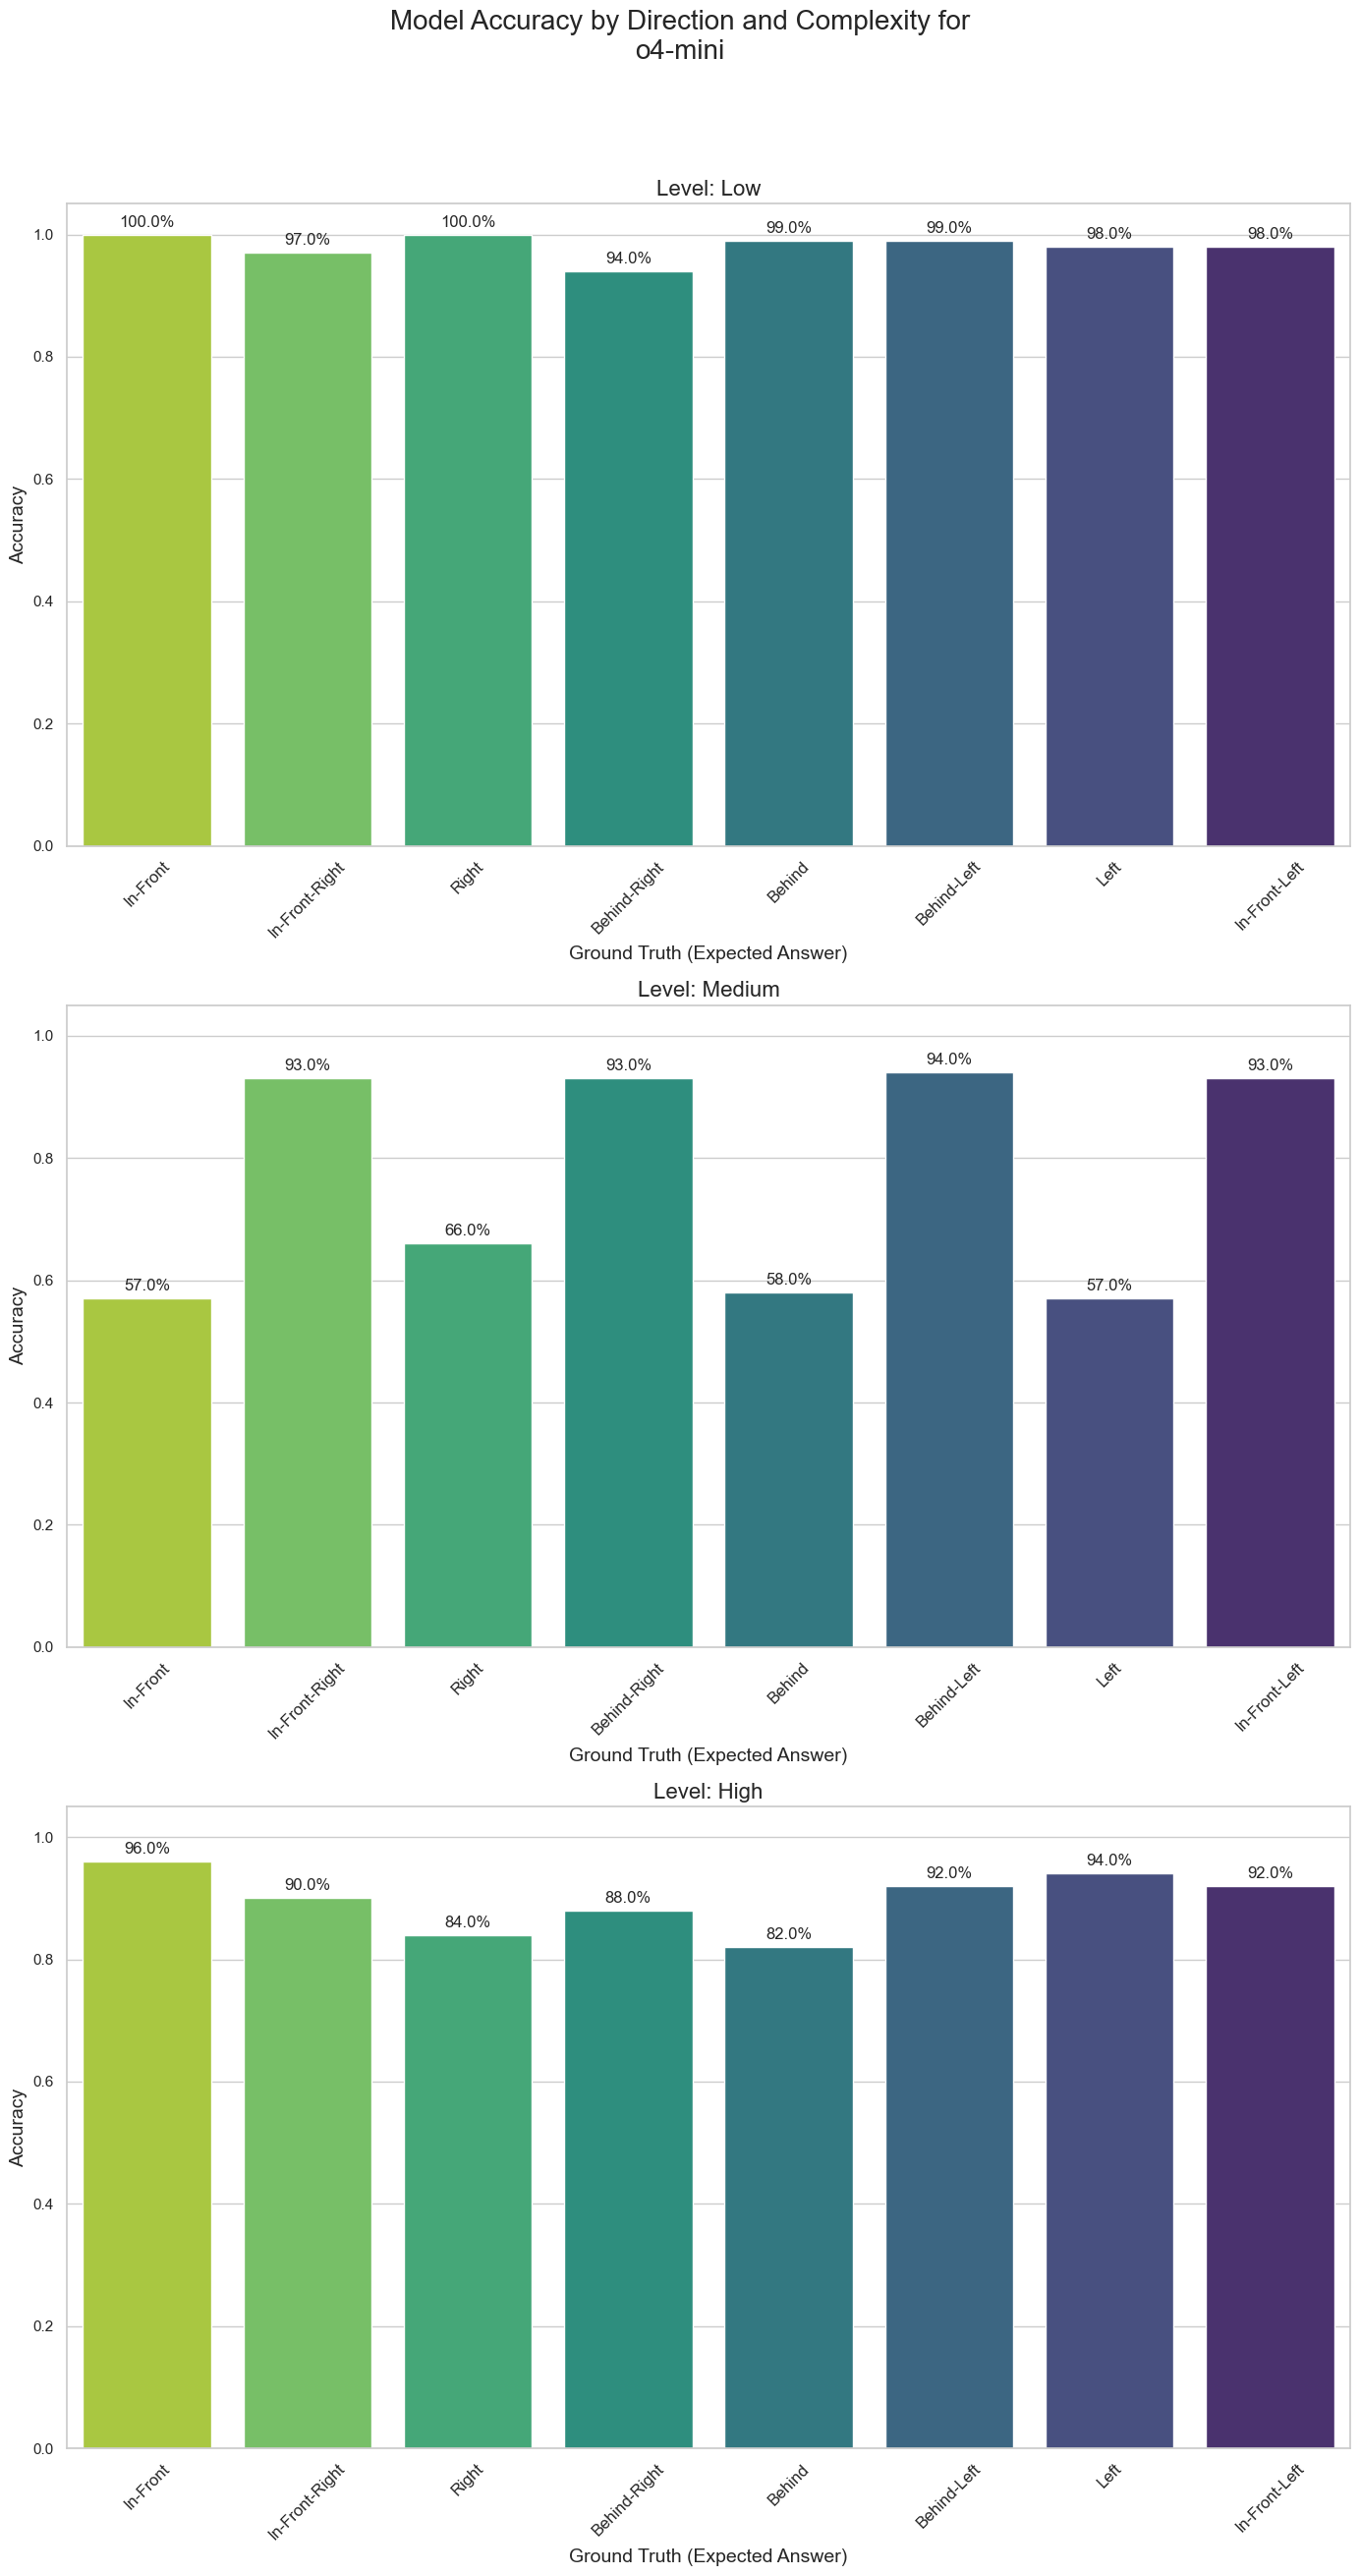


--- Generating detailed charts for model: gpt-4.1 ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

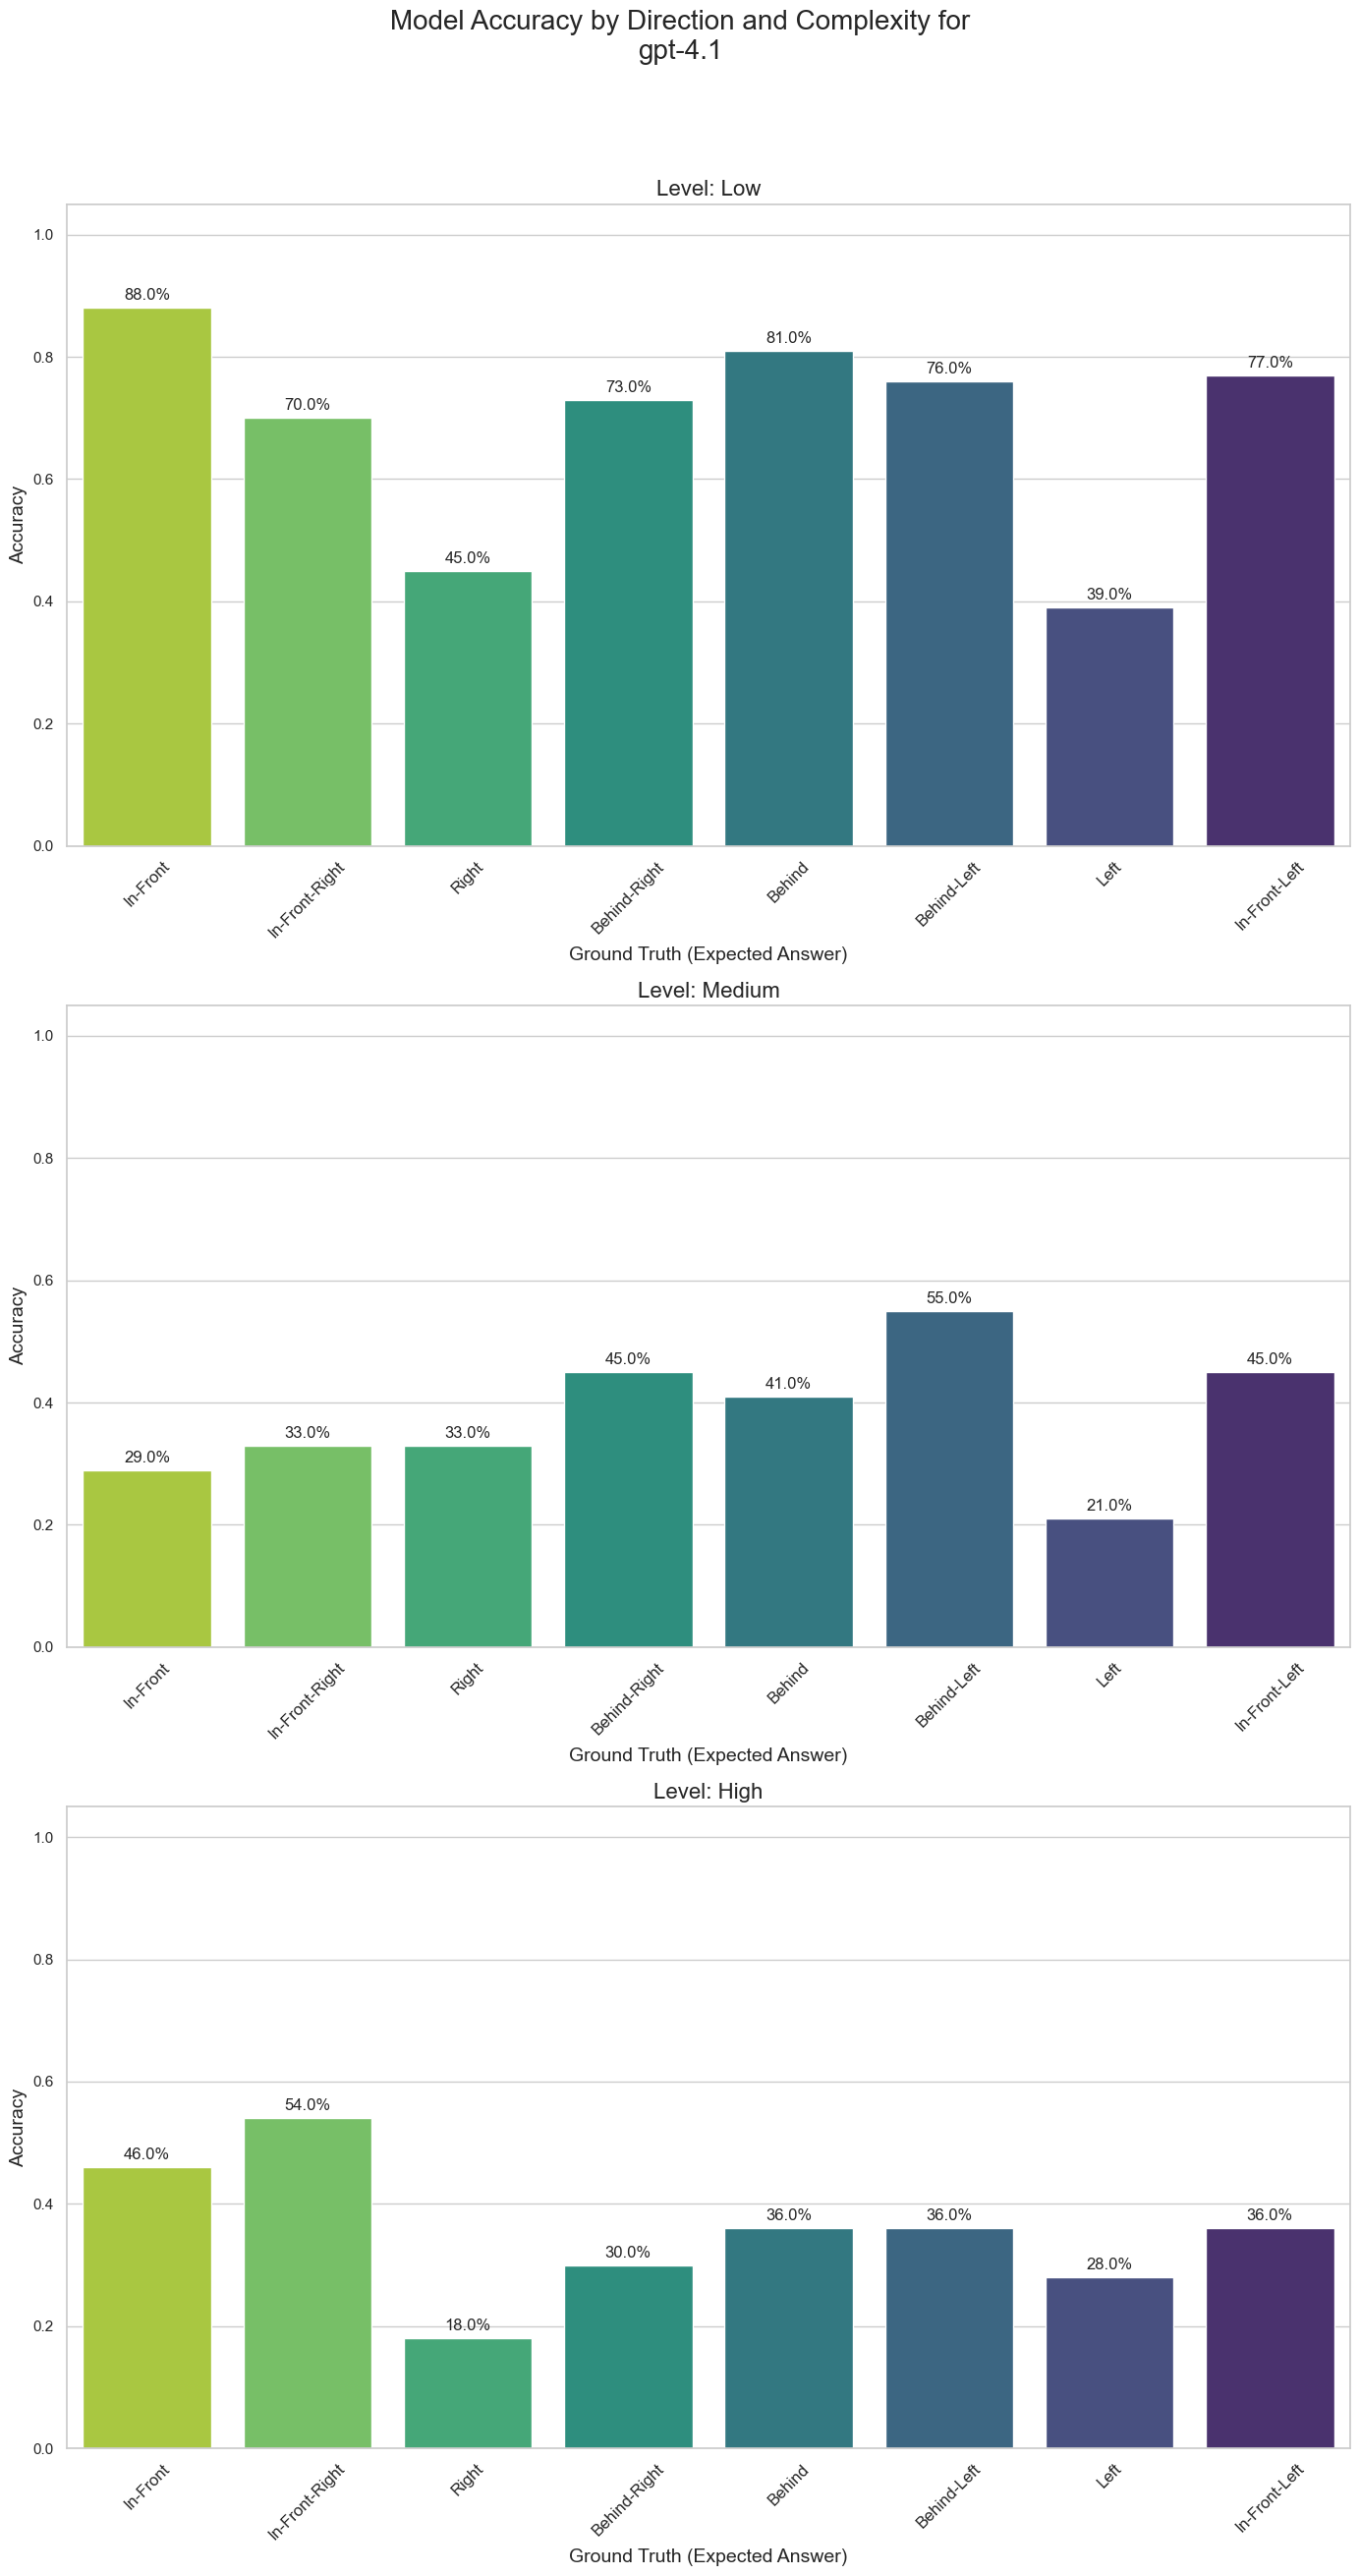


--- Generating detailed charts for model: gpt-4.1-mini ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

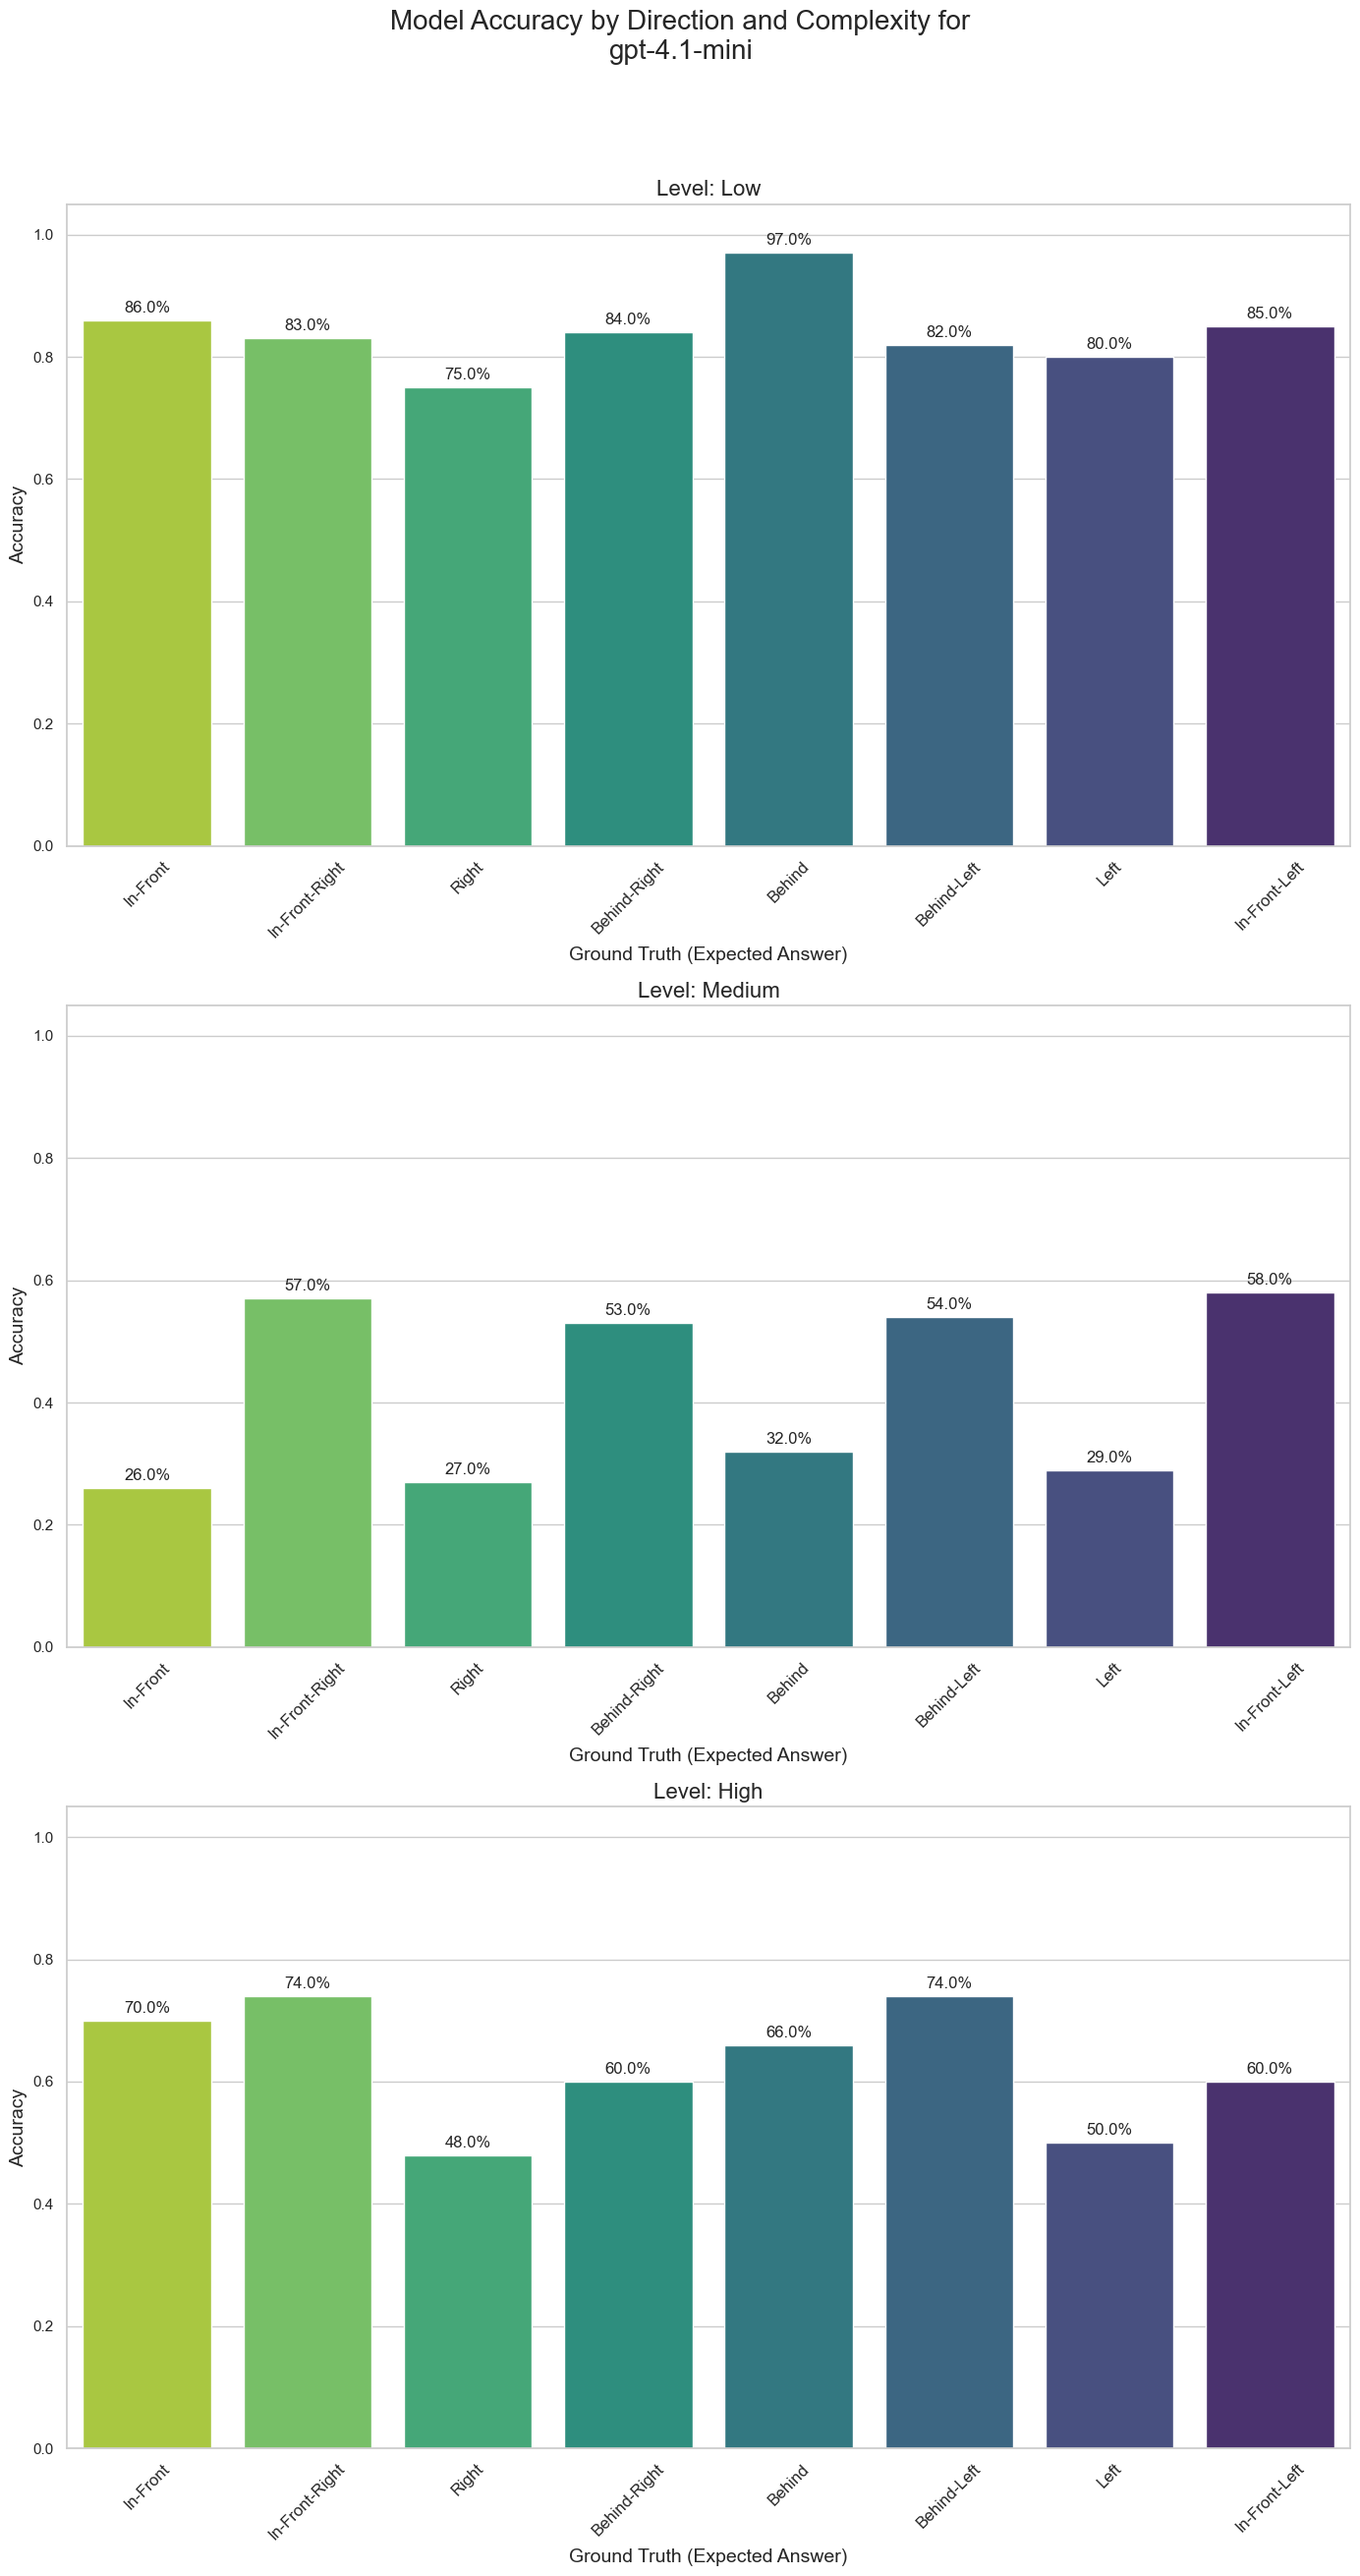


--- Generating detailed charts for model: deepSeek-v3 ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

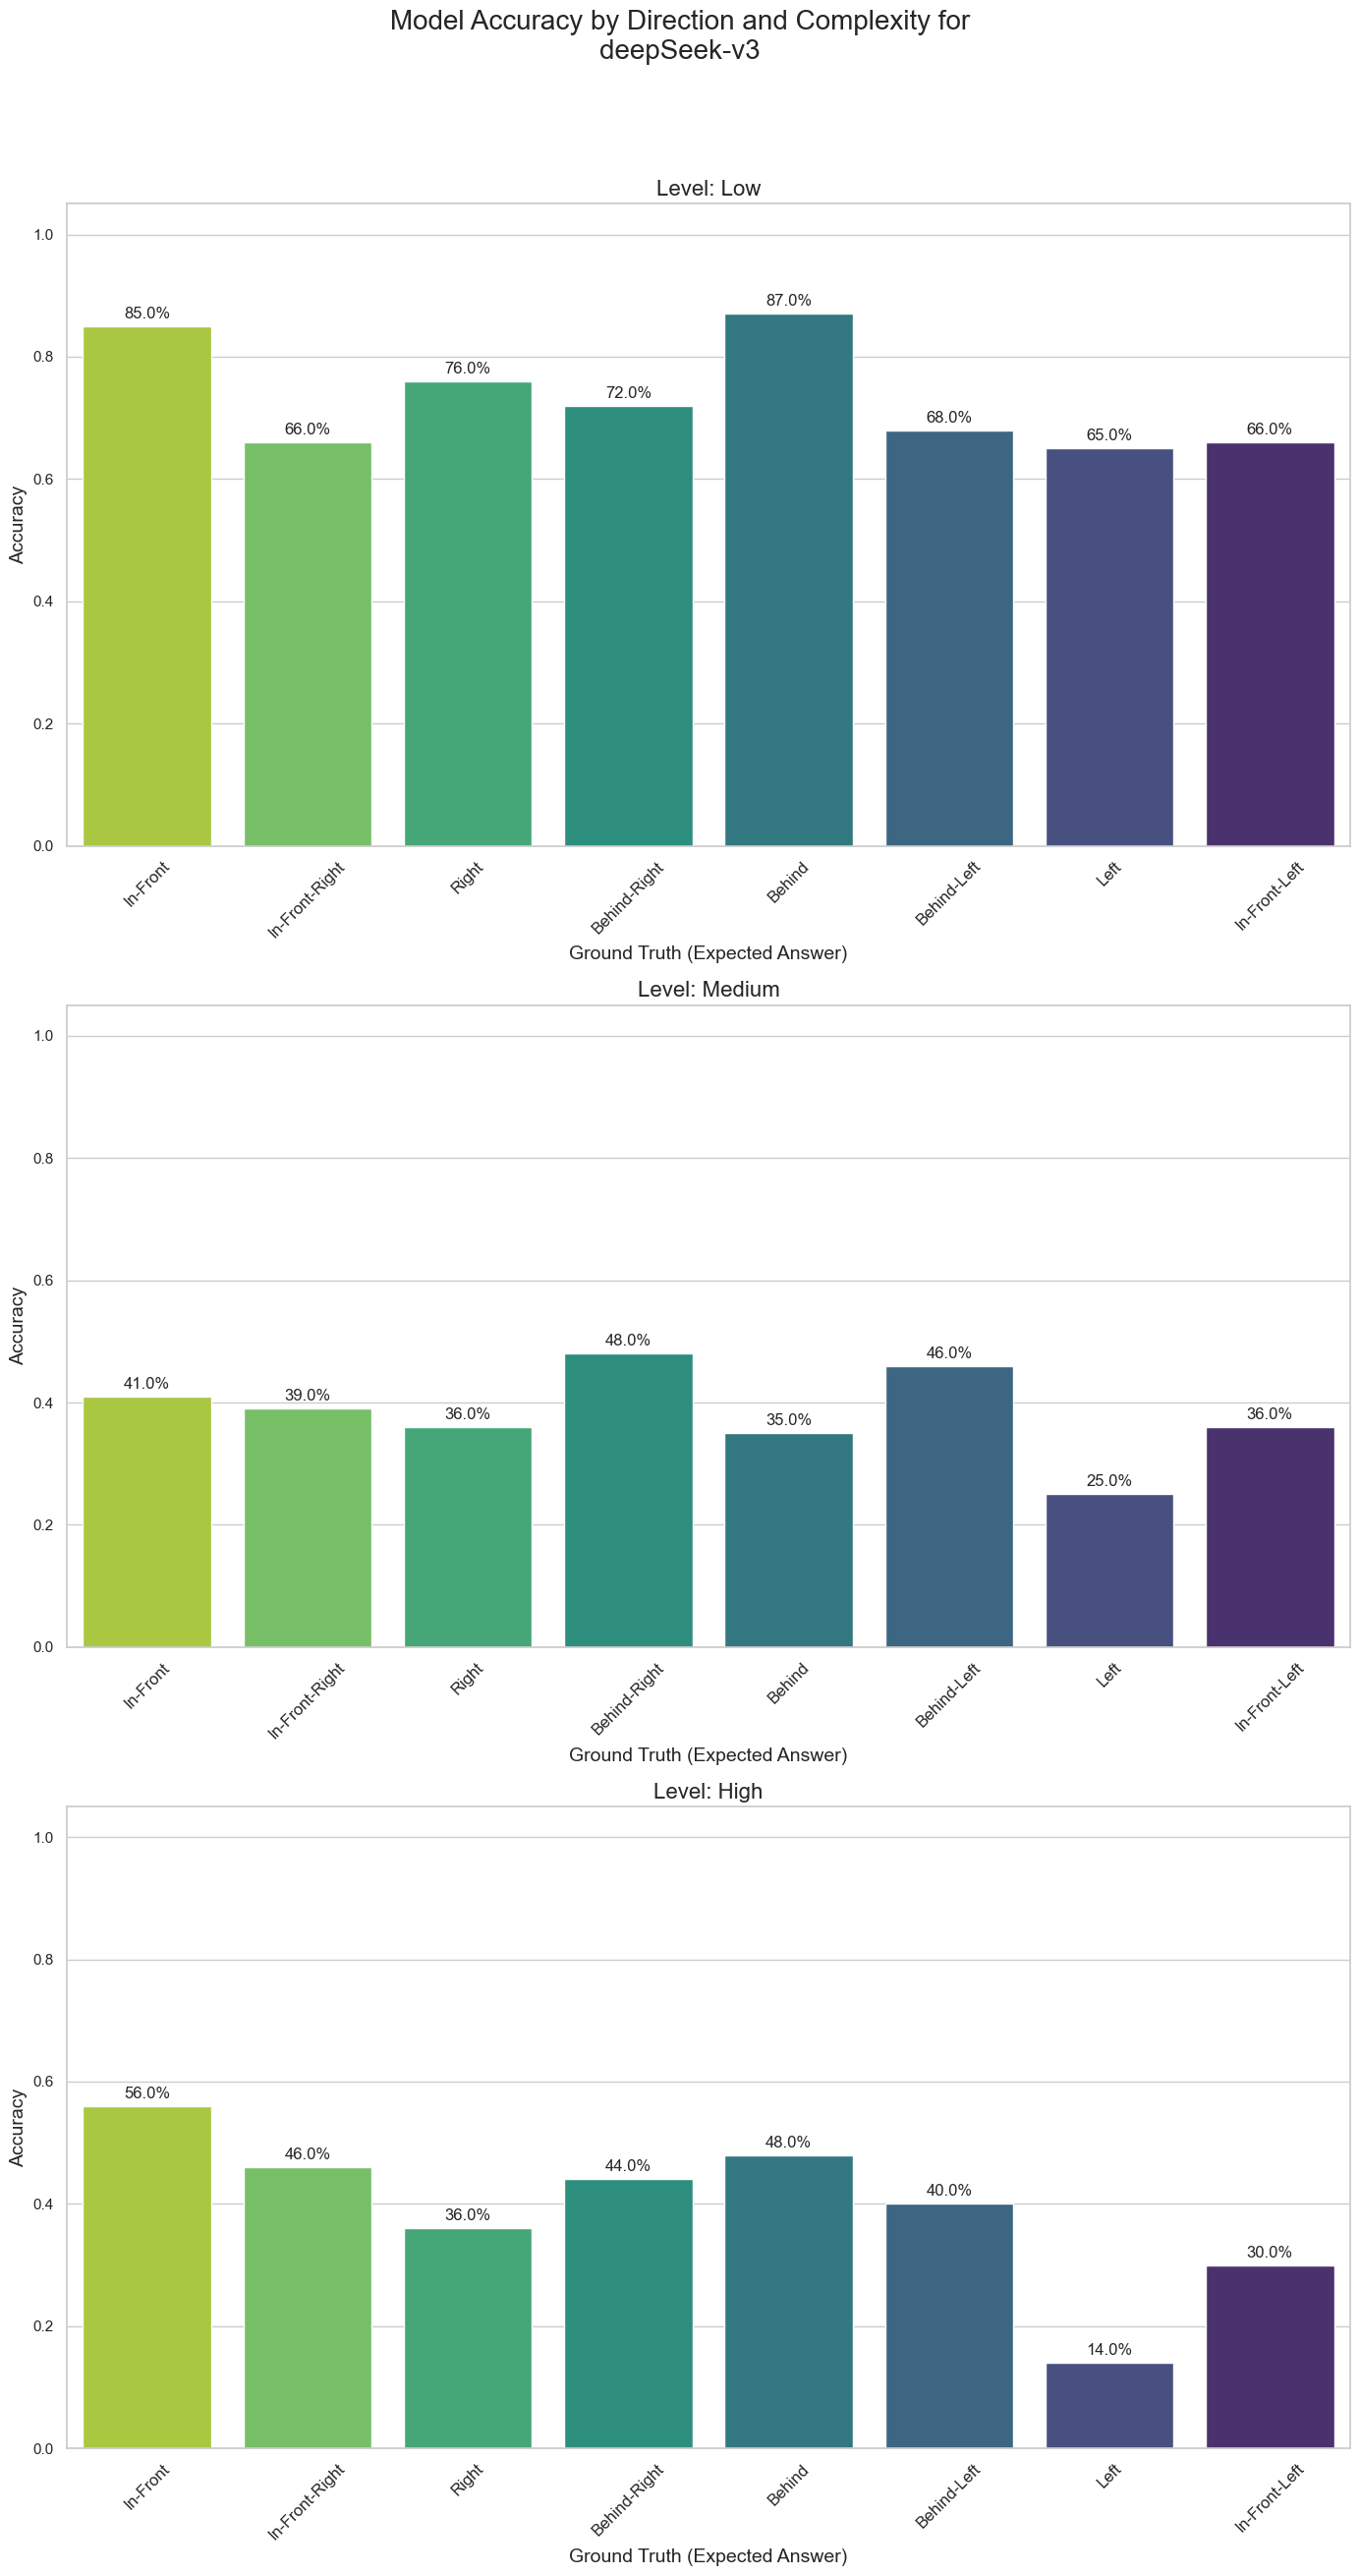


--- Generating detailed charts for model: gemini-2.5-flash ---


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_58603/4148444071.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

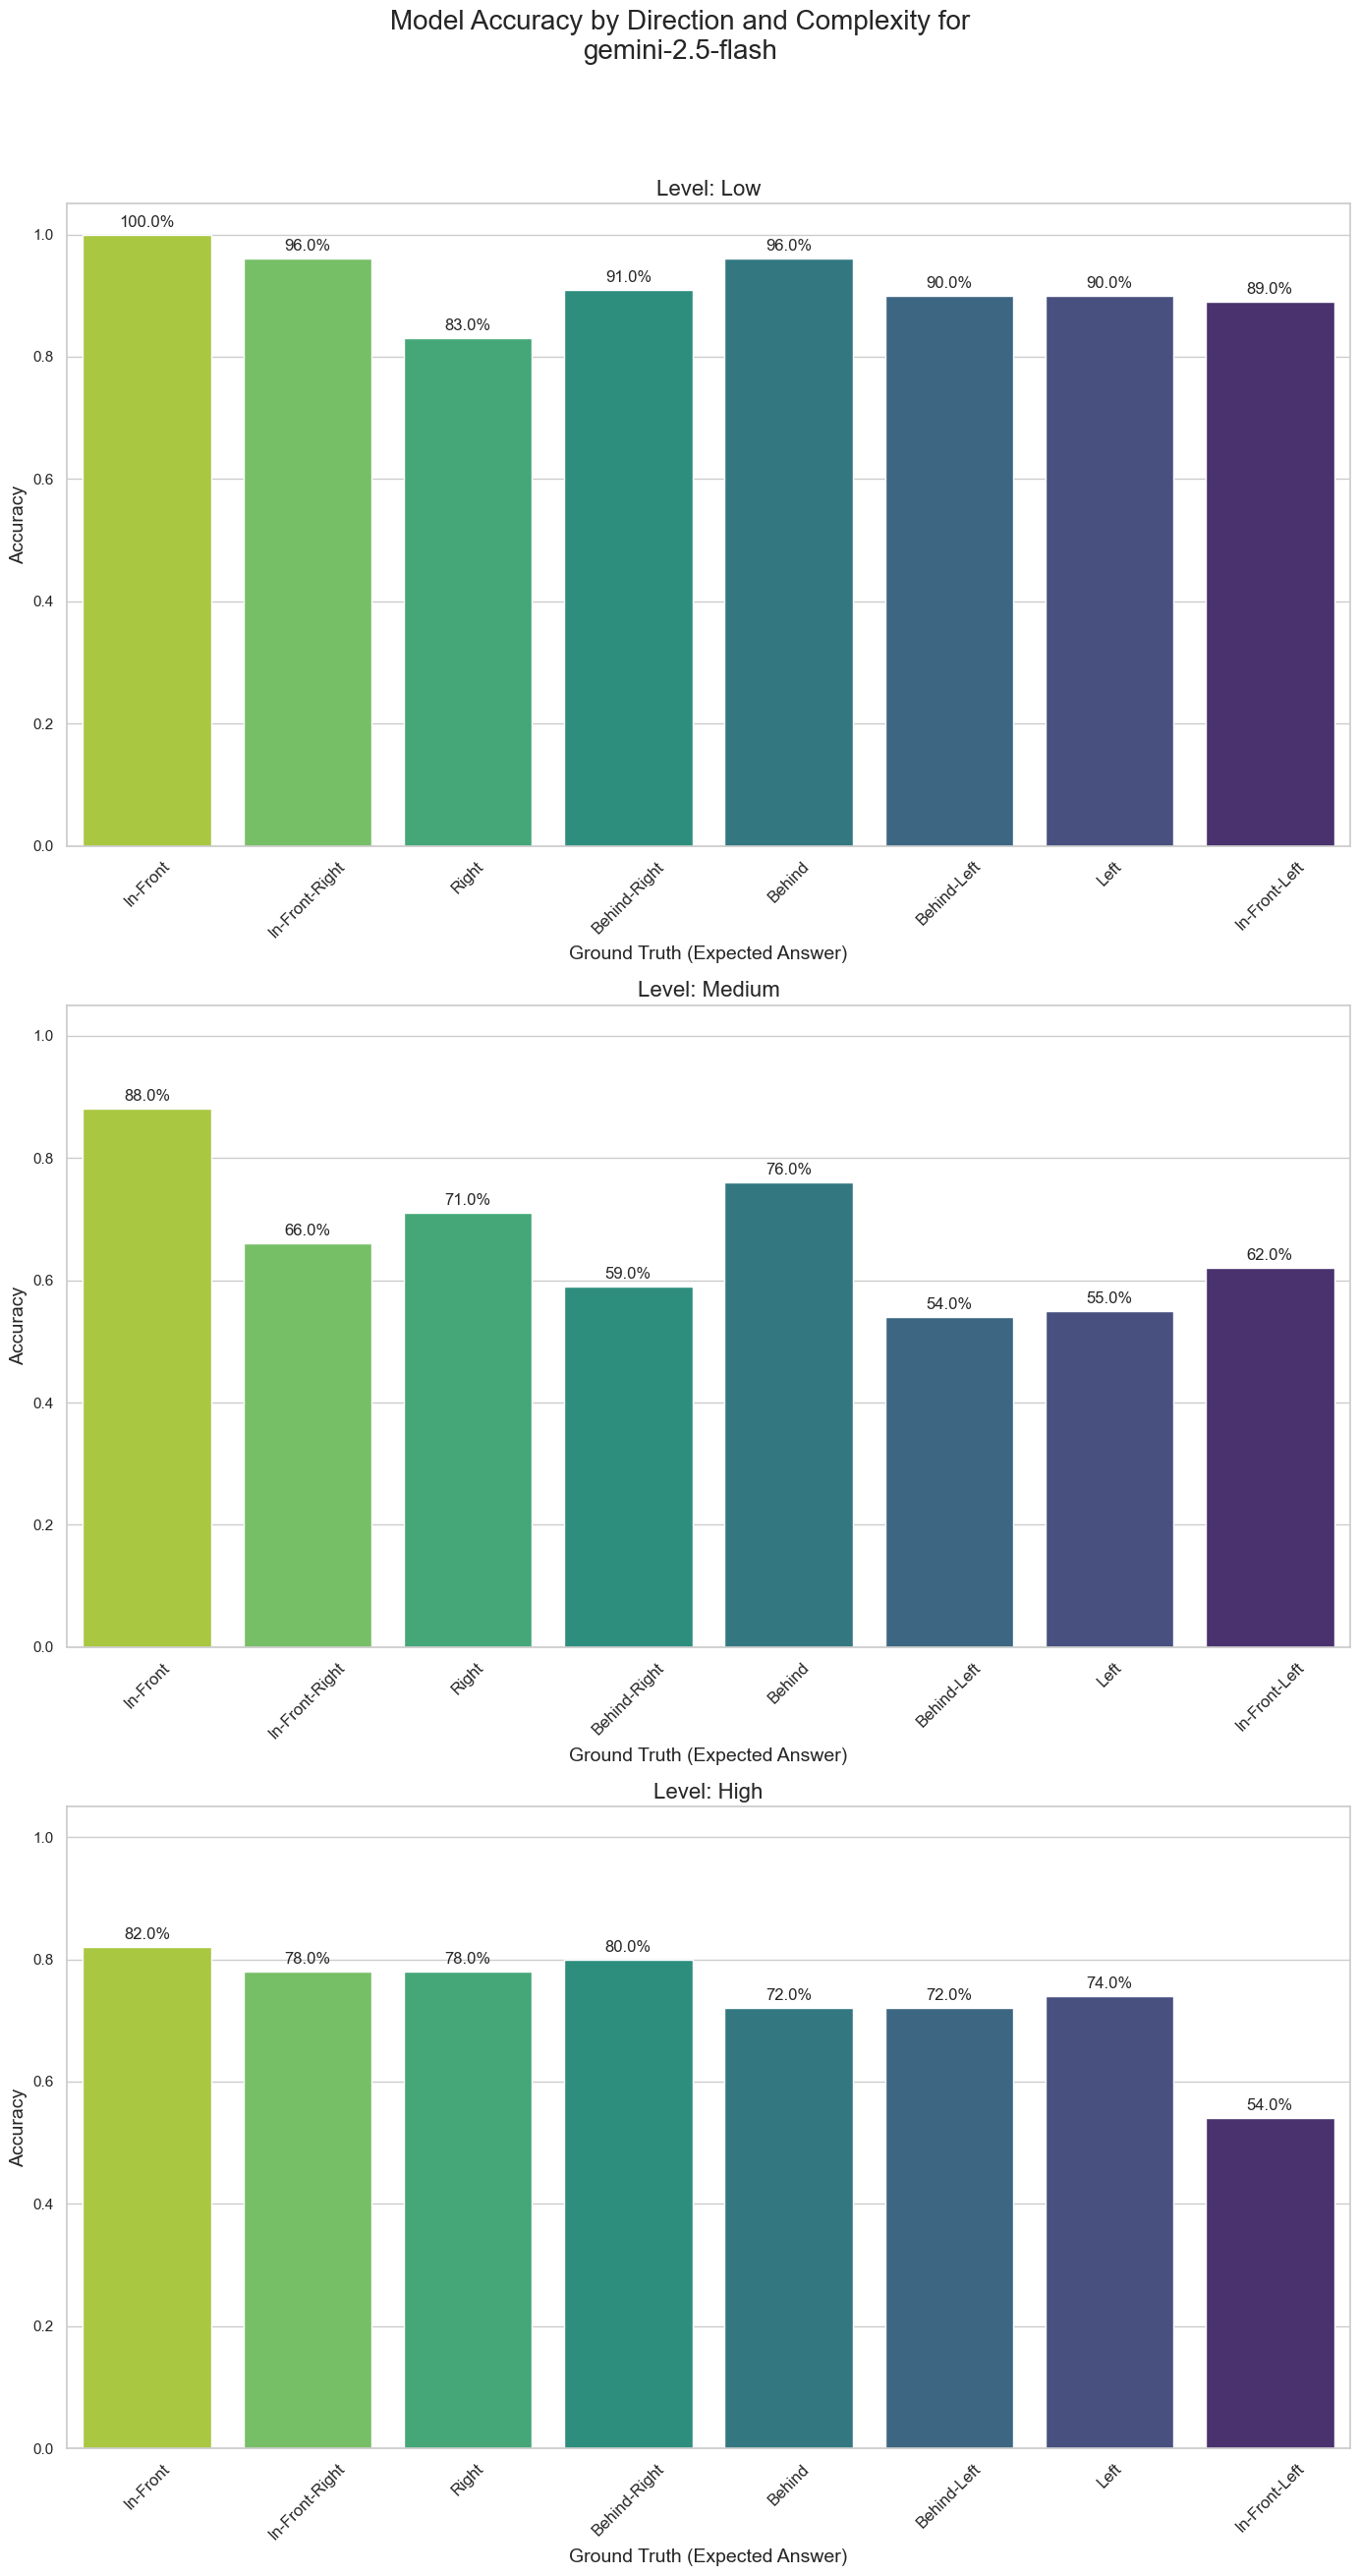

In [7]:
# --- Per-Model, Per-Complexity Drill-Down Analysis (Corrected Labels) ---

print(f"\n{'='*30}\nDETAILED ANALYSIS: ACCURACY PER-MODEL, PER-LEVEL\n{'='*30}")

if not master_df.empty:
    unique_models = master_df['model'].unique()

    # Loop through each model to create a dedicated figure for it
    for model_name in unique_models:
        print(f"\n--- Generating detailed charts for model: {model_name} ---")
        
        df_model = master_df[master_df['model'] == model_name]
        levels = sorted(df_model['level'].unique(), key=lambda x: ['Low', 'Medium', 'High'].index(x))
        
        # Create a figure with subplots. Removed sharex=True to show all labels.
        fig, axes = plt.subplots(len(levels), 1, figsize=(14, 9 * len(levels)), sharey=True)
        
        if len(levels) == 1:
            axes = [axes]
            
        fig.suptitle(f'Model Accuracy by Direction and Complexity for\n{model_name}', fontsize=20, y=1.0)

        direction_order = ['In-Front', 'In-Front-Right', 'Right', 'Behind-Right', 'Behind', 'Behind-Left', 'Left', 'In-Front-Left', 'incorrect prompt', 'unparseable', 'error']

        # Loop through each complexity level for the current model
        for i, level in enumerate(levels):
            ax = axes[i]
            df_level = df_model[df_model['level'] == level]
            
            if df_level.empty:
                ax.set_title(f'Level: {level} (No Data)', fontsize=16)
                continue

            accuracy_by_direction = df_level.groupby('expected_answer')['is_correct'].mean().reindex(direction_order).dropna()

            if accuracy_by_direction.empty:
                ax.set_title(f'Level: {level} (No Correct Answers to Plot)', fontsize=16)
                continue

            sns.barplot(ax=ax, x=accuracy_by_direction.index, y=accuracy_by_direction.values, palette="viridis_r")
            
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)

            ax.set_title(f'Level: {level}', fontsize=16)
            ax.set_ylabel('Accuracy', fontsize=14)
            ax.set_ylim(0, 1.05)
            
            # --- FIX ---
            # Set the x-axis label and rotate the tick labels for EACH subplot
            ax.set_xlabel('Ground Truth (Expected Answer)', fontsize=14)
            ax.tick_params(axis='x', rotation=45, labelsize=12)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(os.path.join(root_results_dir, f'{model_name}_detailed_accuracy_report.png'))
        plt.show()
else:
    print("No data available for detailed analysis.")


DETAILED ANALYSIS: CONFUSION MATRIX PER-MODEL, PER-LEVEL

--- Generating confusion matrices for model: o4-mini ---


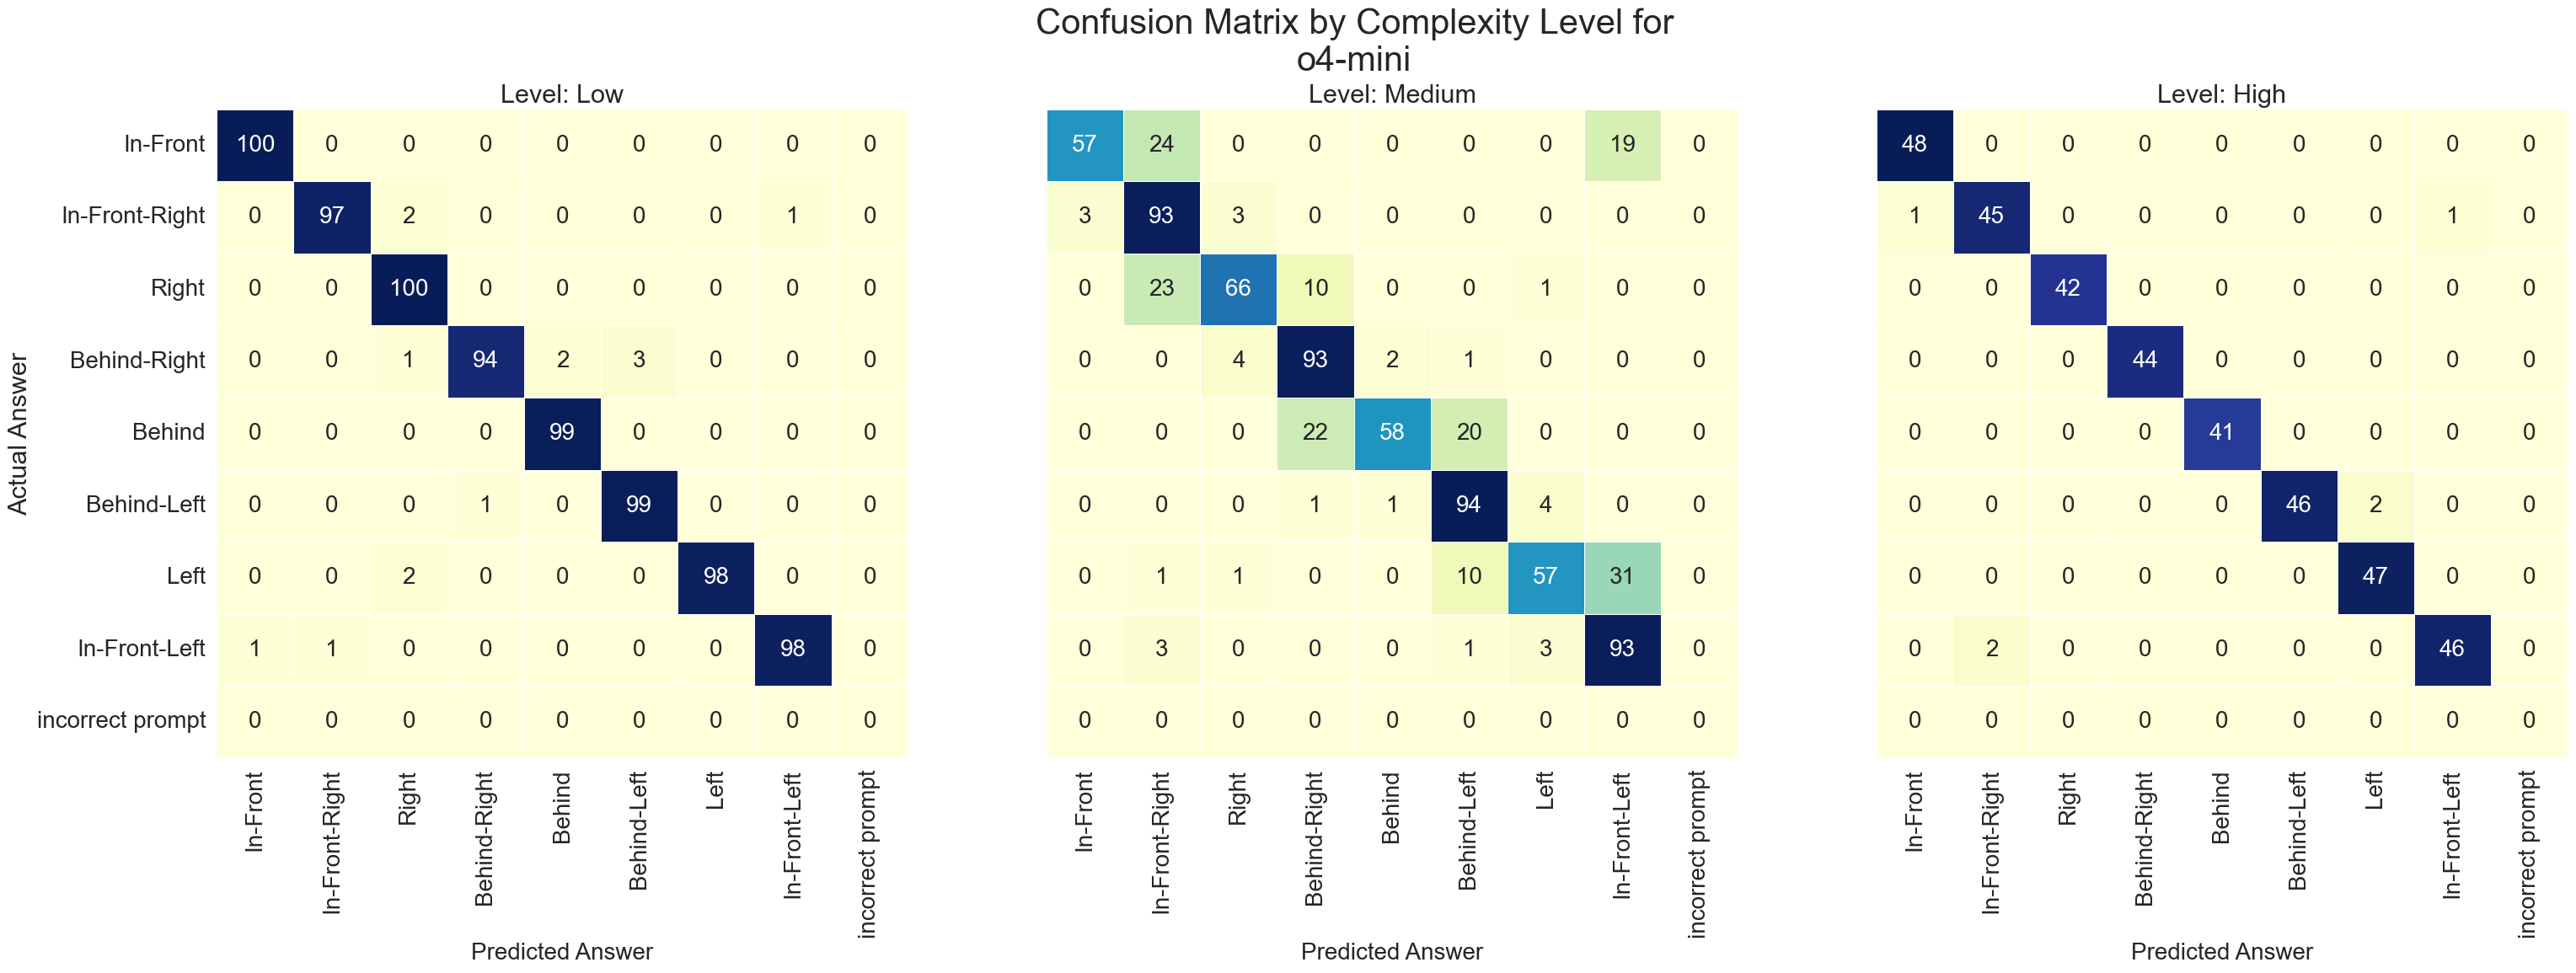


--- Generating confusion matrices for model: gpt-4.1 ---


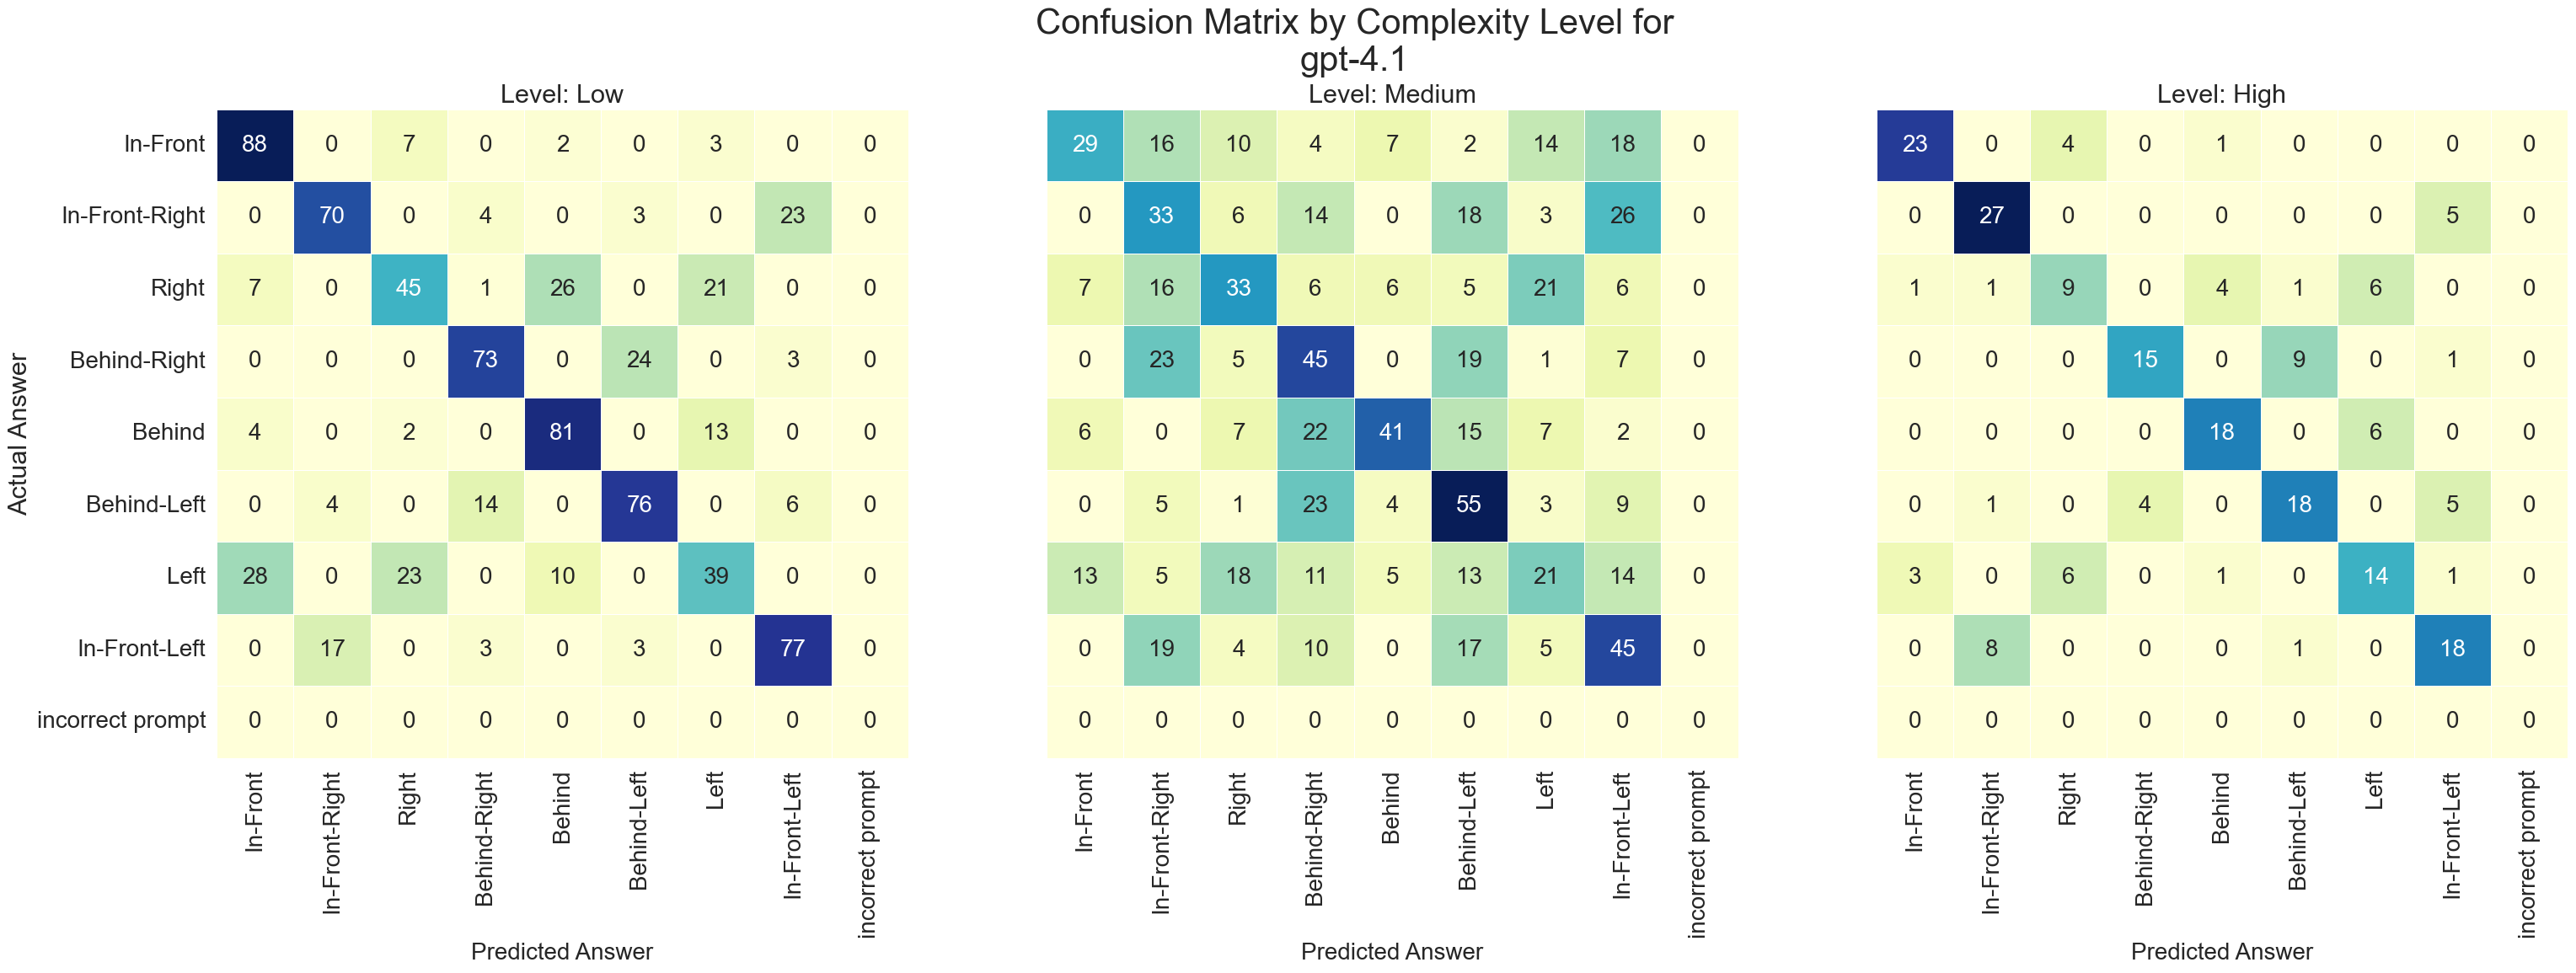


--- Generating confusion matrices for model: gpt-4.1-mini ---


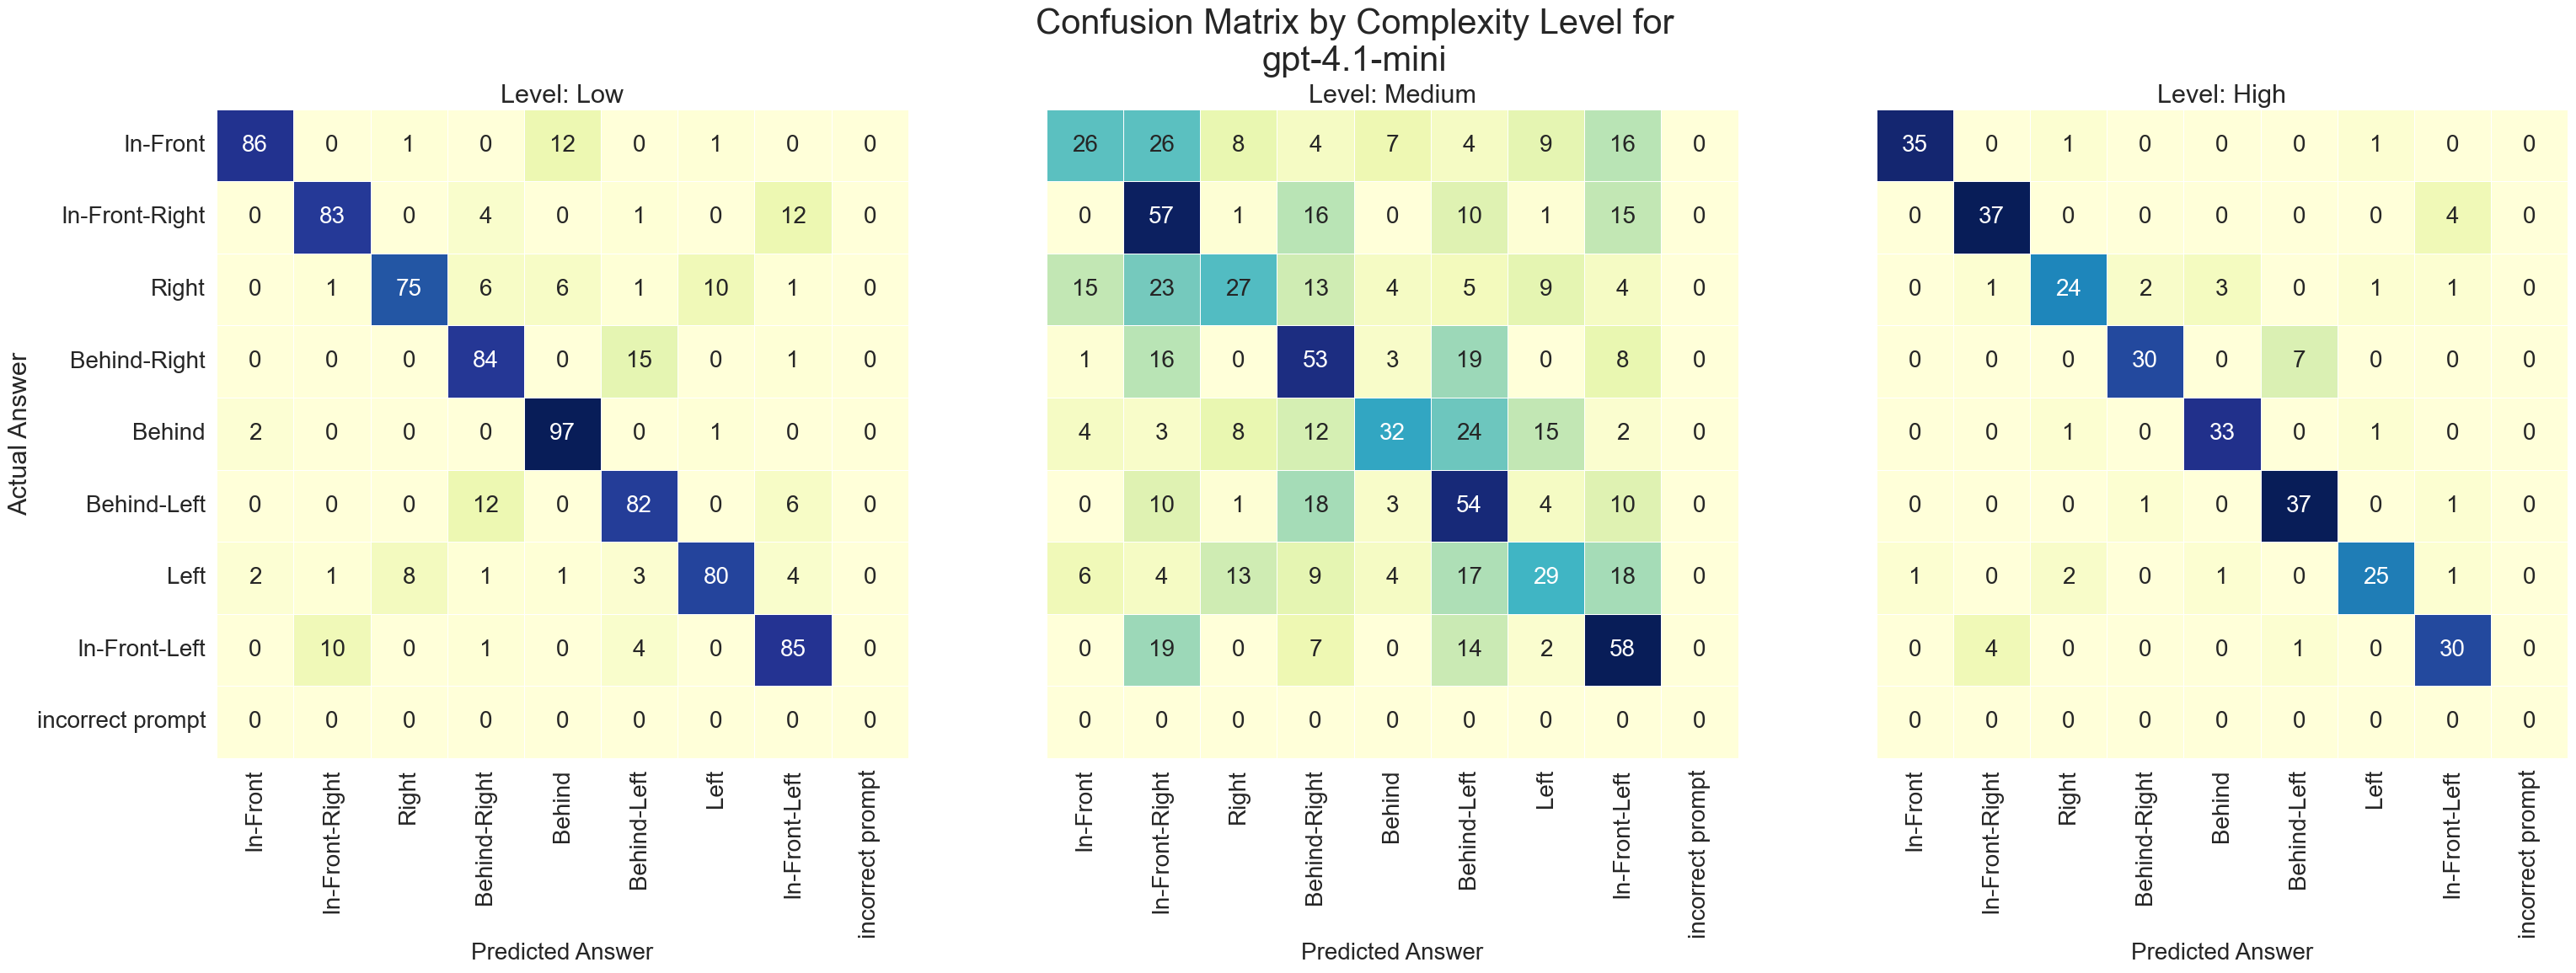


--- Generating confusion matrices for model: deepSeek-v3 ---


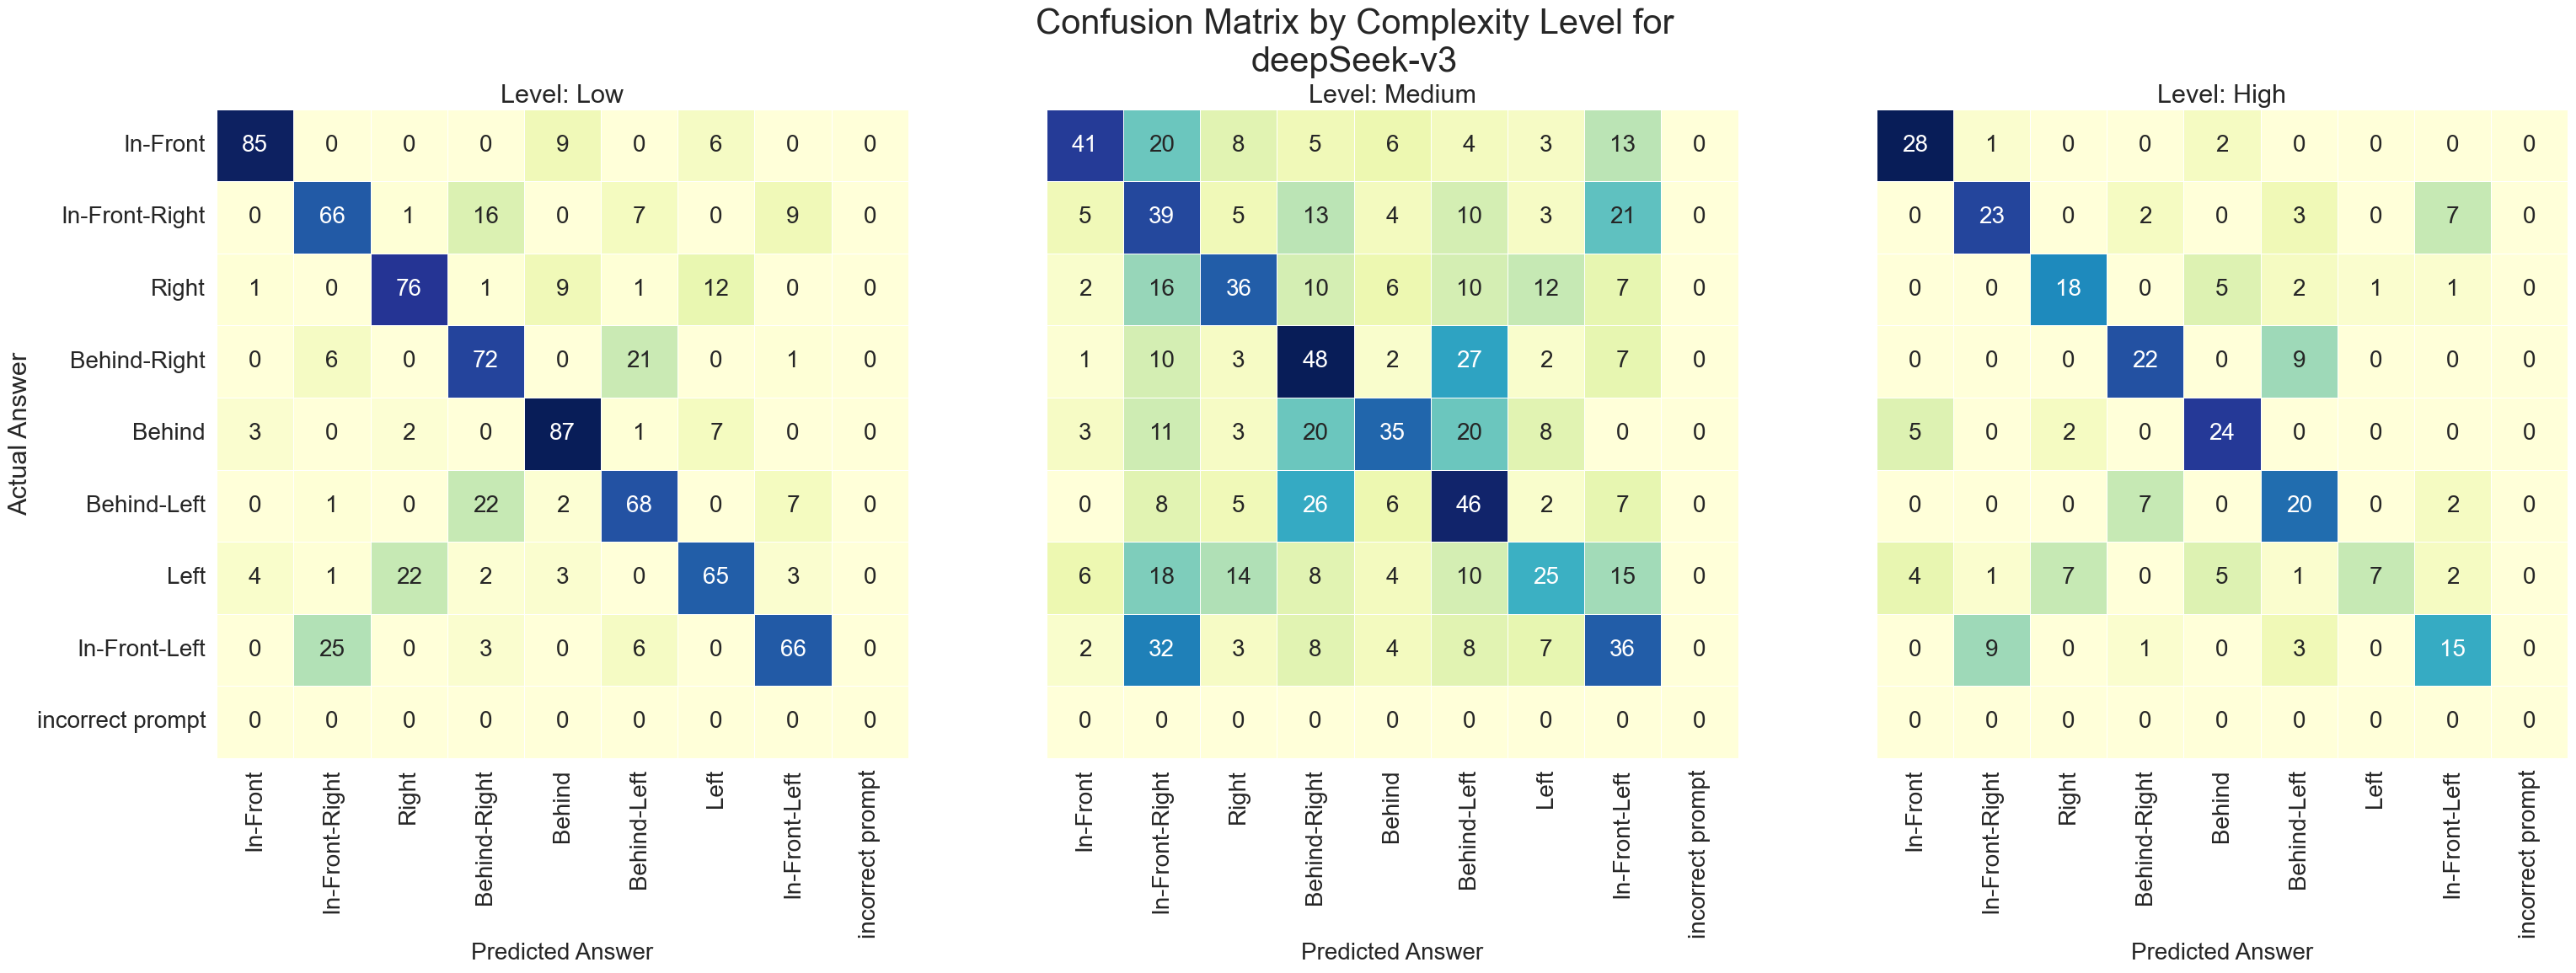


--- Generating confusion matrices for model: gemini-2.5-flash ---


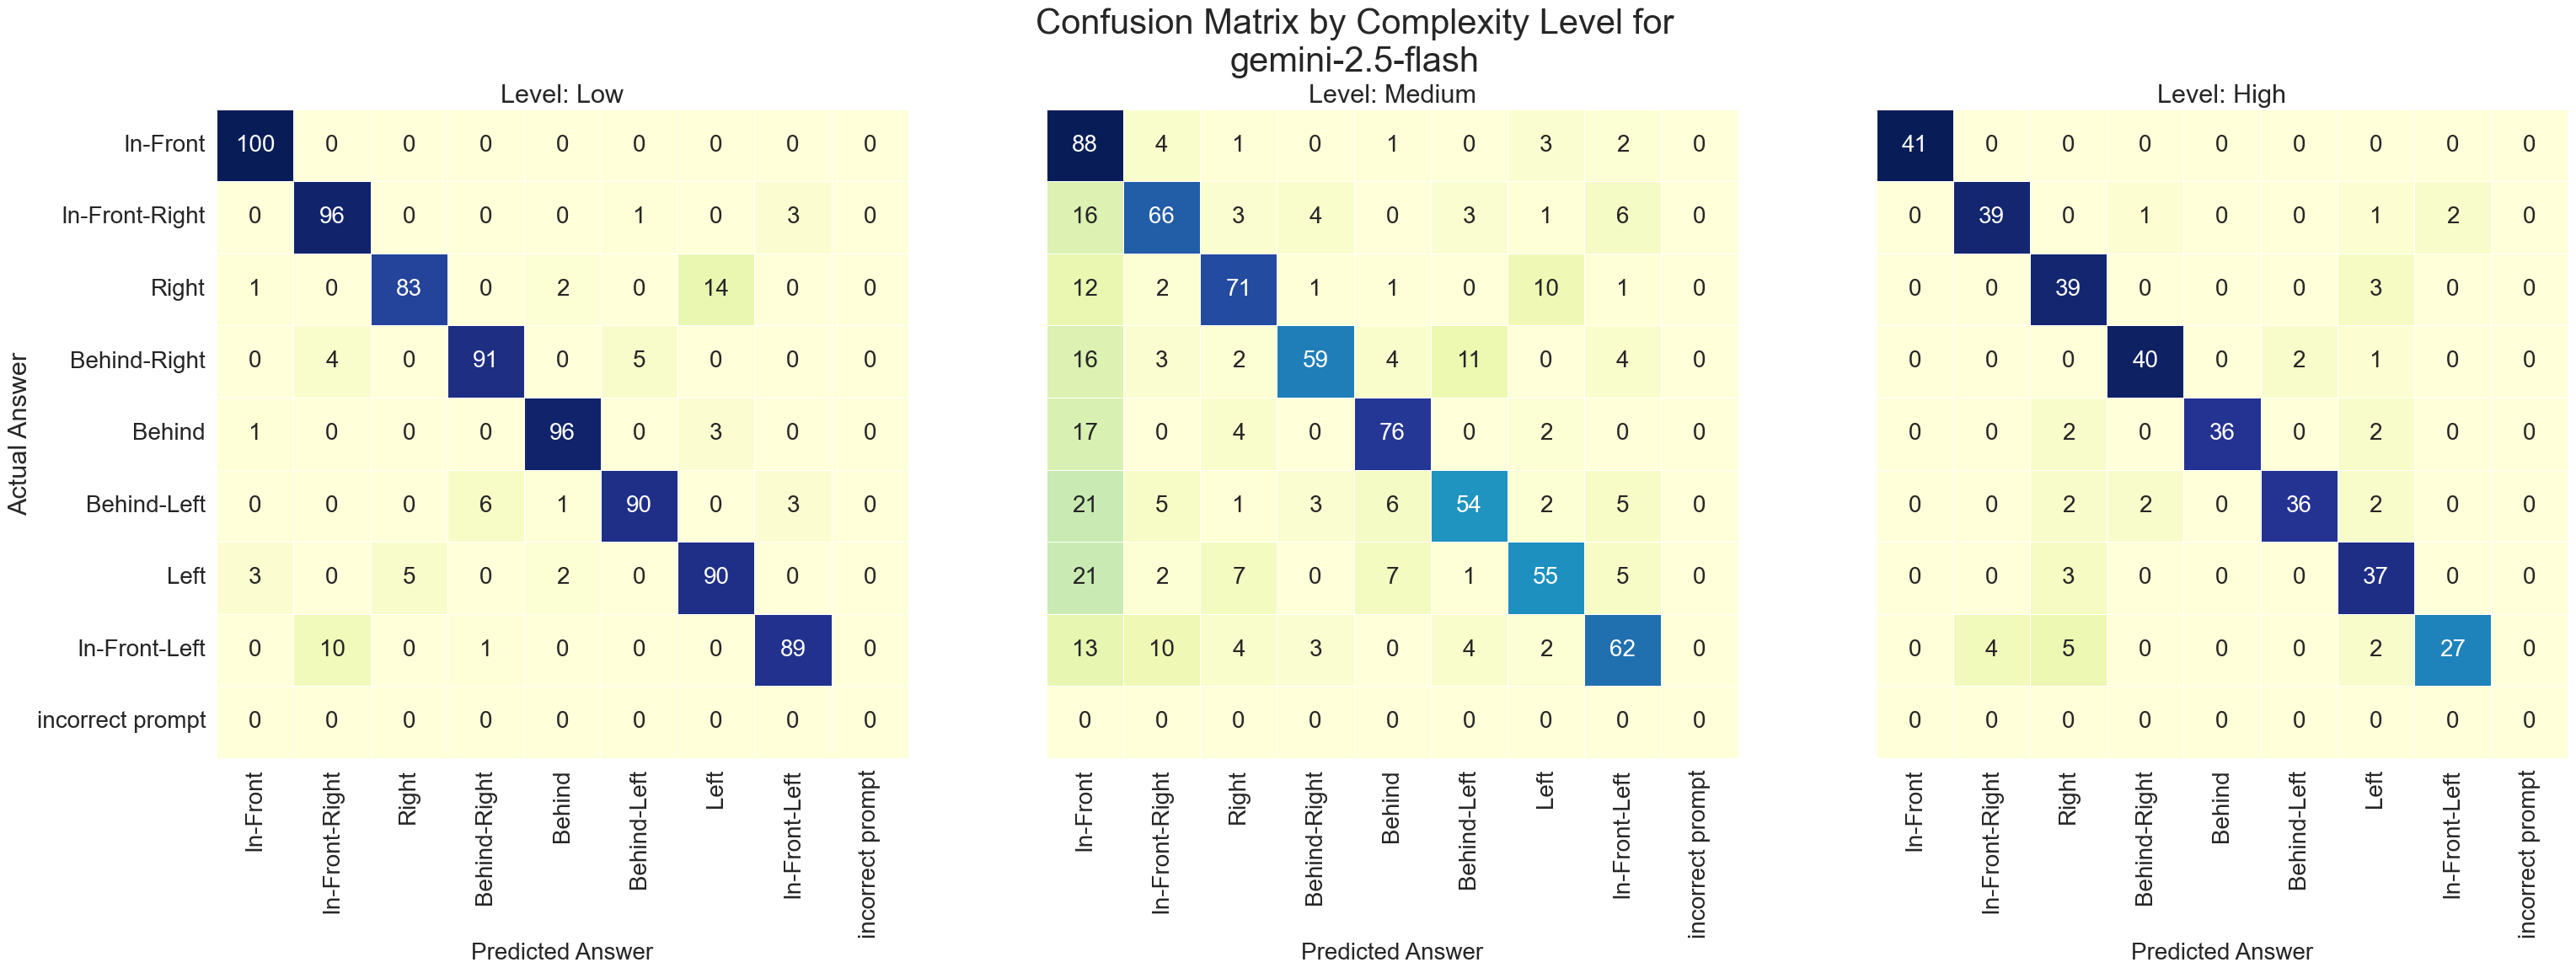

In [8]:
# --- Per-Model, Per-Complexity Confusion Matrix Drill-Down (Error Rows/Columns Removed) ---

print(f"\n{'='*30}\nDETAILED ANALYSIS: CONFUSION MATRIX PER-MODEL, PER-LEVEL\n{'='*30}")

if not master_df.empty:
    unique_models = master_df['model'].unique()

    # --- FIX ---
    # Define the valid answer categories once, outside the loop.
    valid_answers = [
        'In-Front', 'In-Front-Right', 'Right', 'Behind-Right', 
        'Behind', 'Behind-Left', 'Left', 'In-Front-Left', 
        'incorrect prompt'
    ]
    # --- END FIX ---

    for model_name in unique_models:
        print(f"\n--- Generating confusion matrices for model: {model_name} ---")
        
        df_model = master_df[master_df['model'] == model_name]
        levels = sorted(df_model['level'].unique(), key=lambda x: ['Low', 'Medium', 'High'].index(x))
        
        fig, axes = plt.subplots(1, len(levels), figsize=(12 * len(levels), 10), sharey=True)
        if len(levels) == 1: axes = [axes]
            
        fig.suptitle(f'Confusion Matrix by Complexity Level for\n{model_name}', fontsize=30, y=1.0)

        for i, level in enumerate(levels):
            ax = axes[i]
            df_level = df_model[df_model['level'] == level]
            
            if df_level.empty:
                ax.set_title(f'Level: {level}\n(No Data)', fontsize=18)
                continue

            # --- FIX ---
            # 1. Filter the data for this level to exclude 'error' values.
            df_level_filtered = df_level[
                df_level['expected_answer'].isin(valid_answers) & 
                df_level['predicted_answer'].isin(valid_answers)
            ]

            # 2. Create the crosstab using the filtered data and the list of valid answers.
            confusion_matrix_level = pd.crosstab(
                pd.Categorical(df_level_filtered['expected_answer'], categories=valid_answers, ordered=True),
                pd.Categorical(df_level_filtered['predicted_answer'], categories=valid_answers, ordered=True),
                rownames=['Actual Answer'], colnames=['Predicted Answer'], dropna=False
            )
            # --- END FIX ---
            
            sns.heatmap(confusion_matrix_level, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax, linewidths=.5, annot_kws={"size": 20})
            
            ax.set_title(f'Level: {level}', fontsize=22)
            ax.set_ylabel('')
            ax.set_xlabel('Predicted Answer', fontsize=20)
            ax.tick_params(axis='x', rotation=90, labelsize=20)
            ax.tick_params(axis='y', rotation=0, labelsize=20)
        
        axes[0].set_ylabel('Actual Answer', fontsize=22)
        
        #plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(root_results_dir, f'{model_name}_detailed_confusion_matrix.png'))
        plt.show()
else:
    print("No data available for detailed analysis.")

### o4-mini

* The `o4-mini` model is a significant performance outlier, demonstrating robustly high accuracy across all directions and complexity levels, which distinguishes it from all other evaluated models. This confirms its superior and more generalized capability for this reasoning domain.

* Its highest accuracies are achieved on specific, multi-part directions like "Behind-Left" (95.6%), while its lowest are on more ambiguous primary directions like "Behind" (79.2%). This suggests the model excels when spatial relationships are explicitly defined, reducing ambiguity.

* Critically, `o4-mini` does not exhibit the systemic "In-Front" bias seen in other models, having incorrectly predicted it only once when the actual answer was "Behind". This demonstrates that it does not revert to a simple default state when its reasoning fails.

* The model's failures are characterized by nuanced "near-miss" errors, such as confusing a primary direction with a similar diagonal one or incorrectly adding a contextual modifier. This error profile indicates a more sophisticated reasoning process is occurring compared to other models.

* The model's performance shows significant volatility, starting near-perfect at low complexity, experiencing a notable dip at the medium level, and then making a strong rebound at high complexity. This non-linear arc demonstrates a complex relationship between task difficulty and model accuracy.

* The performance dip at the medium level is explained by a divergence in accuracy between directional types. Performance on specific, multi-part directions remained high (e.g., 94.0% for "Behind-Left"), while it plummeted for more ambiguous primary directions (e.g., 57.0% for "Left").

* The rebound at the high level is characterized by the convergence of these directional types. Accuracy on primary directions recovered dramatically, with "Left" for example rebounding to 94.0%, bringing its performance back in line with the consistently high accuracy on complex directions.

* The nature of the model's errors shifted across the levels, with "near-miss" errors spiking at medium complexity before subsiding. For instance, the confusion of "Left" with "In-Front-Left" peaked at 31 instances at the medium level but dropped to just 2 at the high level.

### gpt-4.1

* The `gpt-4.1` model demonstrates a near-total failure in spatial reasoning, with accuracy scores close to zero for most directions, such as 0.8% for "Behind-Left" and 1.2% for "Behind-Right". This indicates a fundamental inability to understand the directional concepts presented in the prompts.

* The model's highest accuracy of 39.2% for the "In-Front" direction is not a result of correct reasoning. It is an artifact of a powerful predictive bias towards that specific answer, as confirmed by its error patterns.

* The confusion matrix confirms the model has collapsed into a simplistic heuristic, overwhelmingly predicting "In-Front" for nearly every actual direction. For example, it predicted "In-Front" 98 times when the correct answer was "Behind-Right" and 87 times when it was "Left".

* This model's performance exemplifies a systemic reasoning collapse, where it relies on a default response rather than attempting to interpret the spatial scene from the prompt. This behavior makes it a primary contributor to the "In-Front" bias observed in the initial consolidated analysis of all models.

* At the lowest complexity, `gpt-4.1` already operates on a flawed heuristic rather than reasoning. It exhibits a strong predictive bias towards "In-Front" and "Left" while showing near-zero accuracy for most other directions.

* Even on the simplest tasks, the model is incapable of identifying most multi-part or diagonal directions. Its accuracy for directions like "In-Front-Right" and "Behind-Left" is 0.0% at the low complexity level, demonstrating a foundational failure to generalize.

* At the medium complexity level, the model's fragile heuristics begin to fail, resulting in further performance degradation. The accuracy for its most biased answer, "In-Front," drops by more than half from 68.0% to 30.0%.

* At high complexity, the model undergoes a catastrophic reasoning collapse where its internal logic completely dissolves. Its accuracy for "In-Front" drops to 0.0%, and its predictions become highly chaotic and disconnected from its previous biases.

* In summary, the model's trajectory is one of progressive failure, moving from a stable but incorrect heuristic on simple tasks to a complete and chaotic breakdown as complexity increases. This illustrates a brittle, pattern-matching approach that is unable to adapt to increasing reasoning demands.

### gpt-4.1-mini

* The `gpt-4.1-mini` model demonstrates a profound failure in spatial reasoning, with accuracy scores in the single digits for most directions, such as 1.2% for "Behind-Right" and 2.8% for "Behind-Left". This indicates a fundamental inability to understand the provided spatial contexts.

* The model's highest accuracy of 41.6% for the "In-Front" direction is an artifact of a strong predictive bias, not genuine reasoning capability. This is confirmed by the confusion matrix, where "In-Front" is the most frequent prediction regardless of the actual answer.

* The confusion matrix shows the model has collapsed into a simplistic heuristic, overwhelmingly predicting "In-Front" for every actual direction. For instance, it incorrectly predicted "In-Front" 80 times when the true answer was "Behind-Left".

* The performance and error profile of `gpt-4.1-mini` are qualitatively identical to the larger `gpt-4.1` model. Both models fail by defaulting to the same incorrect "In-Front" heuristic, suggesting a shared, systemic weakness in this model family.

* In stark contrast to the nuanced, "near-miss" errors of a high-performing model like `o4-mini`, `gpt-4.1-mini`'s reliance on a single default answer highlights a complete absence of a valid reasoning process. This underscores the vast qualitative difference in capabilities between LLMs on this task.

* At the lowest complexity, `gpt-4.1-mini` already operates on a flawed heuristic rather than reasoning. It exhibits a strong predictive bias towards "In-Front," where it scored 81.0%, while showing near-zero capability for most other directions.

* Even on simple tasks, the model is incapable of identifying most multi-part or diagonal directions. Its accuracy for directions like "Behind-Right" and "Behind-Left" is just 1.0% at the low complexity level, demonstrating a foundational failure to generalize.

* At the medium complexity level, the model's limited heuristics begin to fail, causing its performance to degrade significantly. The accuracy for its most biased answer, "In-Front," plummets from 81.0% to just 23.0%.

* At high complexity, the model undergoes a catastrophic reasoning collapse where its internal logic dissolves. Its accuracy for "In-Front" drops to 0.0%, and its predictions become highly chaotic and disconnected from its previous biases.

* In summary, the model's trajectory is one of progressive failure, moving from a stable but incorrect heuristic on simple tasks to a complete and chaotic breakdown as complexity increases. This pattern of failure is nearly identical to that of the larger `gpt-4.1` model.

### deepseek-v3

* The `deepseek-v3` model demonstrates a profound failure in spatial reasoning, with accuracy scores in the single digits for most multi-part directions, such as 1.2% for "Behind-Right" and 1.6% for "In-Front-Left". This indicates a foundational inability to process these concepts.

* The model's highest accuracy of 37.6% for the "In-Front" direction is an artifact of a strong predictive bias. The confusion matrix confirms that "In-Front" is the most frequent incorrect prediction for many directions.

* Unlike other low-performing models that primarily defaulted to one answer, `deepseek-v3` relies on a multi-heuristic failure, defaulting to "In-Front," "Left," and "Right". For instance, when the actual answer was "Behind-Left," its most frequent incorrect predictions were "Right" (57 instances) and "Left" (56 instances).

* This model's performance exemplifies a systemic reasoning collapse, where it relies on a small set of default responses rather than interpreting the spatial scene. Its behavior is characteristic of a model that is pattern-matching incorrectly instead of engaging in logical deduction.

* The performance of `deepseek-v3` confirms that collapsing into a simplistic, heuristic-based response strategy is a common failure mode across different model families on this task. This provides another stark contrast to the sophisticated, nuanced reasoning of a high-performing model like `o4-mini`.

* At the lowest complexity, `deepseek-v3` already operates on a flawed heuristic rather than reasoning. It exhibits a strong predictive bias towards "In-Front," where it scored 66.0%, while showing near-zero capability for most other directions.

* Even on simple tasks, the model is incapable of identifying most multi-part or diagonal directions. Its accuracy for all such directions is in the single digits at the low complexity level, demonstrating a foundational failure to generalize.

* At the medium complexity level, the model's limited heuristics begin to fail, causing its performance to degrade significantly. The accuracy for its most biased answer, "In-Front," plummets from 66.0% to just 28.0%.

* At high complexity, the model undergoes a catastrophic reasoning collapse where its internal logic dissolves. Its accuracy for "In-Front" drops to 0.0%, and its predictions become highly chaotic and disconnected from its previous biases.

* In summary, the model's trajectory is one of progressive failure, moving from a stable but incorrect heuristic on simple tasks to a complete and chaotic breakdown as complexity increases. This pattern of failure is characteristic of the low-performing models in this study.

### gemini-2.5-flash

* The `gemini-2.5-flash` model occupies a clear middle ground, demonstrating uneven but partial reasoning capability. Its accuracy is highly variable by direction, with scores ranging from a high of 78.0% for "In-Front" to a cluster of results in the 40-50% range for other directions.

* The model shows a partial but inconsistent grasp of the reasoning task, achieving moderate accuracies on most directions, such as 48.0% for "Left" and 46.0% for "Right". This level of performance is significantly better than the near-zero results of the low-tier models on these same directions.

* The model's primary failure mode is a significant bias towards incorrectly predicting "In-Front". For instance, when the actual answer was "Right," "In-Front" was the most frequent error, occurring 70 times.

* Unlike the low-performing models, `gemini-2.5-flash` frequently overcomes its primary bias to arrive at the correct answer. It correctly identified "Left" 120 times and "Right" 115 times, demonstrating a genuine, albeit inconsistent, reasoning ability.

* At low complexity, `gemini-2.5-flash` demonstrates genuine reasoning capability with exceptionally high accuracy across all directions, including 100.0% for "In-Front" and 95.0% for "Behind". This performance is comparable to that of the top-tier `o4-mini` on simple tasks.

* This high performance is extremely brittle, as the model's reasoning collapses at medium complexity. Accuracy for most directions plummets, with "Left" for example dropping from 85.0% at low complexity to just 17.0% at medium.

* When its reasoning fails at the medium level, the model reverts to the systemic "In-Front" bias as its primary failure mode. For instance, it incorrectly predicted "In-Front" 58 times when the actual answer was "Left".

* At high complexity, the model's performance disintegrates entirely, where even its "In-Front" bias fails and its accuracy on that direction drops to just 8.0%. Its predictions become chaotic, indicating a total breakdown of its internal

### Overall

* A systemic predictive bias towards "In-Front" was the single most dominant error pattern across the evaluation. This bias served as the primary failure mode for the majority of models, indicating a common collapse into a simplistic, heuristic-based response strategy.

* The low-performing models, such as the `gpt-4.1` family and `deepseek-v3`, did not just make errors but replaced reasoning entirely with this flawed "In-Front" heuristic. Their confusion matrices show that for nearly every prompt, their most frequent prediction was "In-Front," regardless of the actual correct answer.

* The mid-tier `gemini-2.5-flash` demonstrated how this bias acts as a failure state for models with brittle reasoning. It performed with high accuracy and minimal bias on low-complexity tasks but aggressively reverted to the "In-Front" default as soon as task complexity increased.

* In stark contrast, the top-performing `o4-mini` was the only model to completely avoid the systemic "In-Front" bias. Its errors were qualitatively different "near-misses," such as confusing a primary direction with a similar diagonal one, which indicates a more sophisticated reasoning process where errors occur at a higher level of interpretation.

* Task complexity directly influenced the nature of the errors and biases. For low-performing models, high complexity caused their simple biases to dissolve into chaotic, random errors, while for the high-performing `o4-mini`, high complexity *reduced* its nuanced errors by providing disambiguating context.